In [2]:
import patchseq_utils.analysis as utils
from patchseq_utils import plotting as plot
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# fix slow autocomplete
%config Completer.use_jedi = False

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

In [5]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [7]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [8]:
mouse_df = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
human_all = human_df
human_aibs = human_df.query('collaborator=="AIBS"')
mouse_l1 = mouse_df.loc[ lambda df: df['layer_ccf']=='1']
human_l1 = human_df.loc[ lambda df: df['layer']=='1']
margin = 20
# mouse_l12 = mouse_df.loc[ lambda df: df['ccf_depth'] < 115 + margin]
# human_l12 = human_df.loc[ lambda df: (df['layer']=='1') | ((df['layer']=='2') & (df['layer_depth'] < margin))]
human_l12 = human_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2') & (df['normalized_layer_depth'] < 0.5))]
mouse_l12 = mouse_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2/3') & (df['normalized_layer_depth'] < 0.2))]
# human_l1 = human_df.loc[ lambda df: (df['soma_layer']==1)]

# TODO: fillna homology for L1 only??
combined_all_l1 = pd.concat([human_aibs.query("layer=='1'"), mouse_l1], sort=False)
combined = combined_all_l1.dropna(subset=['homology_type']).copy()
combined_morph = pd.concat([human_l1, mouse_l1], 
                           sort=False).dropna(subset=['homology_type']).copy()
combined_l12 = pd.concat([human_l12, mouse_l12], 
                           sort=False).dropna(subset=['homology_type']).copy()

# include collab?
# combined_all = pd.concat([human_df, mouse_df], sort=False).dropna(subset=['homology_type']).sample(frac=1, random_state=42)



In [73]:
human_l12.loc[human_l12.index.difference(human_l1.index)].query('has_morph').homology_type.value_counts()

other    1
VIP      1
MC4R     1
PAX6     1
LAMP5    0
Name: homology_type, dtype: int64

In [74]:
mouse_l12.loc[mouse_l12.index.difference(mouse_l1.index)].query('has_morph').homology_type.value_counts()

LAMP5    3
VIP      1
MC4R     1
PAX6     1
other    0
Name: homology_type, dtype: int64

In [23]:
# TODO: better outlier removal?
combined.loc[lambda df: df['input_resistance'] > 1000, 'input_resistance'] = np.nan

data = combined.loc[combined[ephys_features].notna().sum(axis=1)>0]
morph_remove = ['soma_aligned_dist_from_pia']
morph_features_compare = [x for x in morph_features if x not in morph_remove]
complete_features = np.array(ephys_features)[(data[ephys_features].notna().mean(axis=0)>0.80)]
sig_clusters_human = (data.loc[lambda df: df['species']=='human', 't-type'].value_counts().loc[lambda x: x>5]).index.values
sig_clusters_mouse = (data.loc[lambda df: df['species']=='mouse', cluster].value_counts().loc[lambda x: x>5]).index.values

data[ephys_features].notna().mean(axis=0).sort_values()

peak_deltav_adapt_ratio                   0.000000
adp_v_last_rheo                           0.177885
sag_tau                                   0.269231
low_freq_impedance_chirp                  0.362981
peak_ratio_chirp                          0.362981
sync_freq_chirp                           0.367788
peak_impedance_chirp                      0.367788
3db_freq_chirp                            0.367788
peak_freq_chirp                           0.367788
total_inductive_phase_chirp               0.367788
phase_peak_chirp                          0.367788
phase_low_chirp                           0.367788
mean_isi_rheo                             0.627404
first_isi_inv_rheo                        0.627404
sag_depol                                 0.819712
sag_peak_t_depol                          0.824519
sag_area_depol                            0.824519
isi_norm_sq_var_hero                      0.920673
adapt_hero                                0.920673
ahp_delay_ratio_hero           

In [169]:
mouse_df.project_code.value_counts(dropna=False)

mIVSCC-MET     579
mIVSCC-METx      4
Name: project_code, dtype: int64

In [170]:
mouse_df.cortical_area_ccf.value_counts(dropna=False)

VISp      482
VISpm      50
VISl       26
VISli       7
VIS         6
VISpor      6
VISal       3
VISa        2
VISpl       1
Name: cortical_area_ccf, dtype: int64

Text(0.5, 1.0, 'L1 proportions')

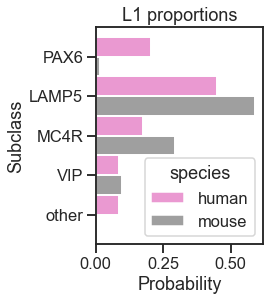

In [172]:
fig, ax = plt.subplots(figsize=(3,4))
sns.histplot(data=combined_morph, y='homology_type', hue='species', palette=species_palette, ax=ax, 
             multiple='dodge', stat='probability', common_norm=False)
# sns.displot(data=combined, y='homology_type', hue='species', palette=species_palette, ax=ax)
ax.set_ylabel('Subclass')
ax.set_title('L1 proportions')

Text(0.5, 1.0, 'homology subclasses - all layers')

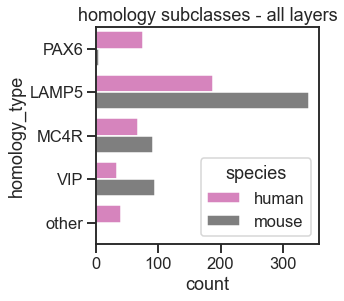

In [173]:
fig, ax = plt.subplots(figsize=(4,4))

sns.countplot(data=combined_all, y='homology_type', hue='species', palette=species_palette, ax=ax, order=homology.keys())
ax.set_title('homology subclasses - all layers')

# Species diff

In [17]:
# combined_all = combined_all[~combined_all.homology_type.str.contains('other')]
# combined = combined[~combined.homology_type.str.contains('other')]

In [77]:
from statsmodels.stats.diagnostic import normal_ad 
def test_normality_worst_case(df, features, group_by=None, test=normal_ad):
    test = lambda x: test(x).pval
    df.groupby(group_by)[features].apply(test).min(axis=0)
    return 

# results = test_normality_worst_case(combined, ephys_features, 'species')

In [79]:
normal_ad(human_df['width_rheo'].dropna())

(2.281631131684321, 8.576830650514694e-06)

In [ ]:
results = utils.run_twosamp(combined, complete_features, 'species')

results.head()

pval_mw   roc_auc        pval_t  cohens_d  nobs  \
feature                                                                  
rheobase_i        1.558220e-64  0.974072  7.336641e-88  1.558110   427   
threshold_i_ramp  2.094566e-63  0.969736  9.362569e-78  1.495629   428   
input_resistance  4.291787e-46  0.899708  3.988058e-48  1.257820   426   
tau               1.419165e-44  0.892708  9.973221e-37  1.123792   426   
peak_deltav_ramp  4.246043e-44  0.889242  4.419567e-54  1.312886   428   

                    pval_t_fdr   pval_mw_fdr  
feature                                       
rheobase_i        6.309511e-86  1.340069e-62  
threshold_i_ramp  4.025905e-76  9.006634e-62  
input_resistance  8.574324e-47  1.230312e-44  
tau               1.225281e-35  3.051206e-43  
peak_deltav_ramp  1.266942e-52  7.303194e-43

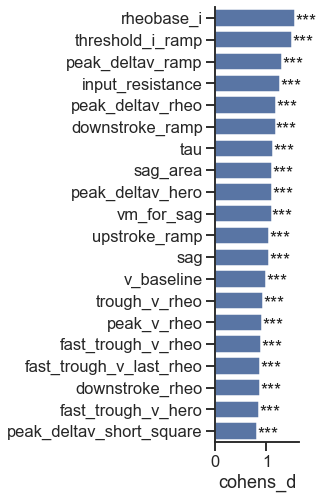

In [13]:
utils.plot_feature_effect_sizes(results, pval='pval_mw', val='cohens_d')

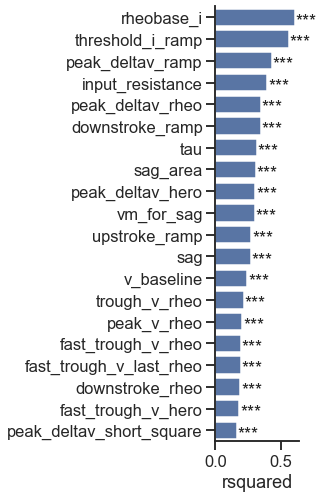

In [14]:
results = utils.run_cluster_anova(combined, complete_features, cluster_var='species')

utils.plot_feature_effect_sizes(results, )

In [23]:
results = utils.run_twosamp(combined_morph, morph_features, 'species')

# utils.plot_feature_effect_sizes(results, pval)
results.head(10)

pval_mw   roc_auc        pval_t  \
feature                                                                    
axon_mean_contraction               2.184431e-12  0.937729  2.831133e-15   
axon_frac_above_basal_dendrite      8.907080e-10  0.878598  2.883904e-09   
basal_dendrite_num_branches         9.786818e-10  0.880952  1.784425e-11   
soma_aligned_dist_from_pia          9.169600e-09  0.858189  1.473985e-07   
axon_frac_intersect_basal_dendrite  1.233610e-07  0.829670  2.196151e-08   
axon_over_basal_dendrite_extent_x   1.117671e-05  0.773940  5.329010e-04   
basal_dendrite_max_branch_order     2.415972e-05  0.757980  1.709932e-05   
axon_bias_y                         7.095164e-05  0.747776  2.307941e-04   
basal_dendrite_soma_percentile_x    7.884873e-05  0.746206  2.280707e-04   
basal_dendrite_mean_contraction     1.466484e-04  0.736787  7.786845e-05   

                                    cohens_d  nobs    pval_t_fdr   pval_mw_fdr  
feature                                                                         
axon_mean_contraction               1.448502    88  1.443878e-13  1.114060e-10  
axon_frac_above_basal_dendrite      1.170138    88  4.902637e-08  1.663759e-08  
basal_dendrite_num_branches         1.289724    88  4.550284e-10  1.663759e-08  
soma_aligned_dist_from_pia          1.057646    88  1.503465e-06  1.169124e-07  
axon_frac_intersect_basal_dendrite  1.114666    88  2.800093e-07  1.258282e-06  
axon_over_basal_dendrite_extent_x   0.728332    88  2.717795e-03  9.500208e-05  
basal_dendrite_max_branch_order     0.887634    88  1.453442e-04  1.760208e-04  
axon_bias_y                         0.770939    88  1.307833e-03  4.468095e-04  
basal_dendrite_soma_percentile_x    0.771523    88  1.307833e-03  4.468095e-04  
basal_dendrite_mean_contraction     0.822281    88  5.673273e-04  7.479066e-04

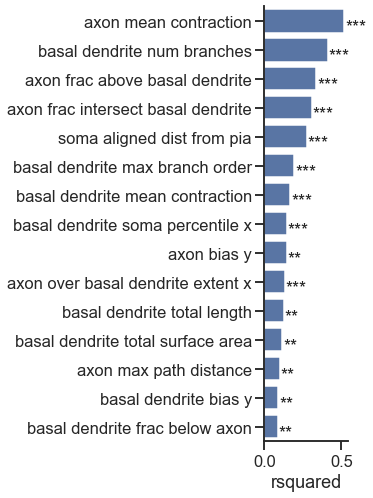

In [24]:
features = morph_features
results = utils.run_cluster_anova(combined_morph, features, cluster_var='species')
ylabels = {x: feature_name(x) for x in features}
utils.plot_feature_effect_sizes(results, nshow=15, ylabels=ylabels)

In [11]:
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ValueWarning
import scipy.stats as stats
import warnings
# warning from subtype not represented in mouse
warnings.filterwarnings("ignore", category=ValueWarning)


In [122]:
reload(utils)

<module 'ateam.analysis.hivscc_analysis' from '/home/tom.chartrand/work/ateam-tools/ateam/analysis/hivscc_analysis.py'>

In [51]:
def run_species_subclass_stats(data, features, compare='species', group_var='homology_type', groups=None, rank=True,
                               cutoff=0.05, fdr_anova='fdr_bh', fdr_subgroup=None, anova_type=1):
    results = utils.fit_models(data, [f"{compare}*{group_var}"], features, rank=rank, anova_type=1);
    pvals = [x for x in results.columns if 'pval' in x]
    results[pvals] = (results[pvals].pipe(pd.DataFrame)#in case this is Series
            .apply(lambda col: multipletests(col, method=fdr_anova)[1]).astype(float))
    results = results.sort_values(f'eta_p_{compare}', ascending=False).set_index('feature')
    results['interaction'] = results[f"pval_{compare}:{group_var}"] < cutoff
    
    cols = [f'eta_p_{compare}', f'pval_{compare}', f"pval_{compare}:{group_var}", 'rsquared', 'interaction']
    interaction_features = results.loc[results.interaction].index
    interaction_results = subgroup_comparisons(data, interaction_features, group_var, groups, compare, 
                                               cutoff=cutoff, fdr_method=fdr_subgroup)
    return results[cols].join(interaction_results)

def subgroup_comparisons(df, features, group_var, groups, compare, fdr_method=None, cutoff=0.05):
    records = []
    pval_names = [f"pval_{x}" for x in groups]
    for feature in features:
        pvals = {}
        for group in groups:
            data = df.loc[df[group_var]==group]
            grouped = data.dropna(subset=[compare, feature]).groupby(compare)
            subsets = [x[feature] for _, x in grouped]
            if len(subsets) == 2:
                u, pval_mw = stats.mannwhitneyu(*subsets)
                pvals[group] = pval_mw
        pval_vals = np.array(list(pvals.values()))
        if fdr_method is not None:
            pval_vals = multipletests(pval_vals, method=fdr_method)[1]
        pval_results = dict(zip(pvals.keys(), pval_vals))
        sig_groups = ", ".join(np.array(list(pvals.keys()))[pval_vals < cutoff])
        records.append(dict(feature=feature, sig_groups=sig_groups, **pval_results))
    results = pd.DataFrame.from_records(records).set_index('feature')
    return results

In [52]:
groups = ['PAX6', 'LAMP5', 'MC4R', 'VIP']
results = run_species_subclass_stats(combined, complete_features, groups=groups)
results.head(10)

eta_p_species   pval_species  pval_species:homology_type  \
feature                                                                         
rheobase_i                0.735217  3.106971e-113                3.692487e-06   
threshold_i_ramp          0.712574  4.366866e-107                1.139215e-06   
tau                       0.664653   2.427938e-93                6.647717e-14   
input_resistance          0.608827   1.408337e-80                1.051303e-07   
downstroke_ramp           0.472168   2.151705e-55                2.240787e-02   
peak_deltav_ramp          0.461421   9.616263e-54                6.345218e-03   
input_resistance_ss       0.453894   2.348757e-52                1.557499e-08   
sag_area                  0.413285   2.744448e-46                7.427206e-14   
sag                       0.388803   7.588905e-43                7.528508e-09   
upstroke_ramp             0.381005   5.111051e-42                1.601696e-07   

                     rsquared  interaction              sig_groups      PAX6  \
feature                                                                        
rheobase_i           0.757212         True  PAX6, LAMP5, MC4R, VIP  0.000976   
threshold_i_ramp     0.734751         True  PAX6, LAMP5, MC4R, VIP  0.001240   
tau                  0.735580         True       PAX6, LAMP5, MC4R  0.017486   
input_resistance     0.691299         True       PAX6, LAMP5, MC4R  0.000238   
downstroke_ramp      0.512007         True  PAX6, LAMP5, MC4R, VIP  0.000079   
peak_deltav_ramp     0.489516         True  PAX6, LAMP5, MC4R, VIP  0.007090   
input_resistance_ss  0.556134         True       PAX6, LAMP5, MC4R  0.000068   
sag_area             0.538040         True        LAMP5, MC4R, VIP  0.973600   
sag                  0.536345         True  PAX6, LAMP5, MC4R, VIP  0.038129   
upstroke_ramp        0.463229         True       PAX6, LAMP5, MC4R  0.003831   

                            LAMP5          MC4R       VIP  
feature                                                    
rheobase_i           1.050136e-33  2.217091e-15  0.000007  
threshold_i_ramp     1.853806e-32  1.220681e-14  0.000003  
tau                  4.094081e-32  1.192795e-14  0.525979  
input_resistance     1.760933e-28  6.892746e-15  0.080500  
downstroke_ramp      1.688319e-26  2.118863e-09  0.017958  
peak_deltav_ramp     1.477991e-23  2.019951e-09  0.039673  
input_resistance_ss  7.497562e-24  1.885399e-07  0.097926  
sag_area             1.252055e-16  3.361582e-19  0.000014  
sag                  5.258197e-26  1.519690e-14  0.000021  
upstroke_ramp        3.960579e-24  6.959090e-07  0.467251

In [19]:
results = run_species_subclass_stats(combined, complete_features, groups=groups, rank=False)
results.head(10)

eta_p_species  pval_species:homology_type  rsquared  \
feature                                                                 
rheobase_i             0.660912                1.643652e-07  0.694026   
threshold_i_ramp       0.596690                1.258752e-06  0.631635   
tau                    0.531663                3.742216e-17  0.636628   
input_resistance       0.506279                4.919872e-05  0.614368   
sag                    0.447180                6.865829e-28  0.664128   
downstroke_ramp        0.436858                5.042535e-02  0.479591   
peak_deltav_ramp       0.432597                1.532902e-02  0.460157   
sag_area               0.421768                1.867395e-18  0.564040   
peak_deltav_rheo       0.349295                2.821754e-04  0.394259   
upstroke_ramp          0.346711                3.558671e-09  0.451081   

                  interaction              sig_groups      PAX6         LAMP5  \
feature                                                                         
rheobase_i               True  PAX6, LAMP5, MC4R, VIP  0.000976  1.050136e-33   
threshold_i_ramp         True  PAX6, LAMP5, MC4R, VIP  0.001240  1.853806e-32   
tau                      True       PAX6, LAMP5, MC4R  0.017486  4.094081e-32   
input_resistance         True       PAX6, LAMP5, MC4R  0.000267  1.760933e-28   
sag                      True  PAX6, LAMP5, MC4R, VIP  0.038129  5.258197e-26   
downstroke_ramp         False                     NaN       NaN           NaN   
peak_deltav_ramp         True  PAX6, LAMP5, MC4R, VIP  0.007090  1.477991e-23   
sag_area                 True        LAMP5, MC4R, VIP  0.973600  1.252055e-16   
peak_deltav_rheo         True             LAMP5, MC4R  0.092488  9.076237e-23   
upstroke_ramp            True       PAX6, LAMP5, MC4R  0.003831  3.960579e-24   

                          MC4R       VIP  
feature                                   
rheobase_i        2.217091e-15  0.000007  
threshold_i_ramp  1.220681e-14  0.000003  
tau               1.192795e-14  0.525979  
input_resistance  6.892746e-15  0.080500  
sag               1.519690e-14  0.000021  
downstroke_ramp            NaN       NaN  
peak_deltav_ramp  2.019951e-09  0.039673  
sag_area          3.361582e-19  0.000014  
peak_deltav_rheo  6.676653e-07  0.816532  
upstroke_ramp     6.959090e-07  0.467251

In [81]:
results = run_species_subclass_stats(combined_morph, morph_features_compare, groups=groups)
# results.to_csv("cross_species_morpho_stats.csv")
results

eta_p_species  pval_species  \
feature                                                                 
axon_mean_contraction                          0.559615  1.882205e-17   
axon_frac_above_basal_dendrite                 0.402441  3.445390e-11   
basal_dendrite_num_branches                    0.386833  8.280223e-11   
axon_frac_intersect_basal_dendrite             0.277198  2.301393e-07   
basal_dendrite_mean_contraction                0.229252  4.679729e-06   
basal_dendrite_max_branch_order                0.196684  3.179356e-05   
axon_over_basal_dendrite_extent_x              0.171697  1.300361e-04   
axon_emd_with_basal_dendrite                   0.149947  3.750607e-04   
axon_max_path_distance                         0.149200  3.750607e-04   
basal_dendrite_extent_x_over_y                 0.148544  3.750607e-04   
basal_dendrite_soma_percentile_x               0.145785  4.029012e-04   
basal_dendrite_extent_x                        0.126758  1.156350e-03   
axon_max_euclidean_distance                    0.115136  2.127867e-03   
axon_bias_y                                    0.111066  2.512965e-03   
axon_extent_x                                  0.089434  8.358292e-03   
axon_depth_pc_0                                0.086007  9.575439e-03   
basal_dendrite_total_length                    0.082801  1.087096e-02   
basal_dendrite_soma_percentile_y               0.078876  1.291493e-02   
axon_total_length                              0.074338  1.595162e-02   
basal_dendrite_total_surface_area              0.066953  2.334518e-02   
basal_dendrite_bias_y                          0.065144  2.471938e-02   
basal_dendrite_max_path_distance               0.057825  3.626296e-02   
axon_over_basal_dendrite_ratio_xy              0.055646  3.943784e-02   
basal_dendrite_frac_below_axon                 0.050653  5.076536e-02   
axon_soma_percentile_y                         0.044707  6.941349e-02   
basal_dendrite_frac_above_axon                 0.041141  8.265304e-02   
axon_extent_y                                  0.025016  2.148713e-01   
axon_frac_below_basal_dendrite                 0.020606  2.612263e-01   
basal_dendrite_extent_y                        0.020399  2.612263e-01   
basal_dendrite_frac_intersect_axon             0.020358  2.612263e-01   
axon_num_branches                              0.019448  2.684223e-01   
axon_bias_x                                    0.018853  2.705014e-01   
axon_exit_theta                                0.017048  2.886789e-01   
basal_dendrite_max_euclidean_distance          0.016979  2.886789e-01   
basal_dendrite_mean_diameter                   0.013876  3.473147e-01   
axon_max_branch_order                          0.011440  4.021259e-01   
basal_dendrite_calculate_number_of_stems       0.008597  4.849728e-01   
basal_dendrite_bias_x                          0.004804  6.455364e-01   
axon_depth_pc_2                                0.004579  6.455364e-01   
axon_depth_pc_1                                0.003815  6.769530e-01   
basal_dendrite_stem_exit_down                  0.002832  7.279143e-01   
basal_dendrite_stem_exit_up                    0.002643  7.279143e-01   
axon_extent_x_over_y                           0.001328  8.220573e-01   
axon_exit_distance                             0.001284  8.220573e-01   
axon_soma_percentile_x                         0.000889  8.538058e-01   
basal_dendrite_stem_exit_side                  0.000650  8.708842e-01   
axon_over_basal_dendrite_extent_y              0.000423  8.866919e-01   
axon_depth_pc_4                                0.000361  8.866919e-01   
axon_depth_pc_3                                0.000070  9.451604e-01   
soma_surface_area                              0.000049  9.451604e-01   

                                          pval_species:homology_type  \
feature                                                                
axon_mean_contraction                                       0.966386   
axon_frac_above_basal_dendrit

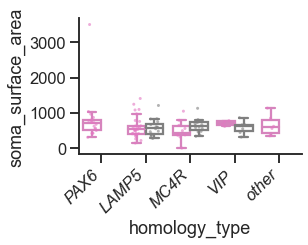

In [82]:
plot.box_strip(data=combined_morph, x='homology_type', y='soma_surface_area', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

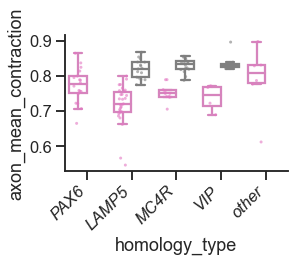

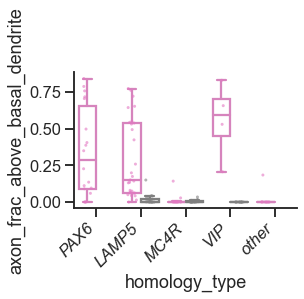

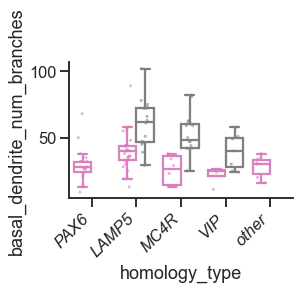

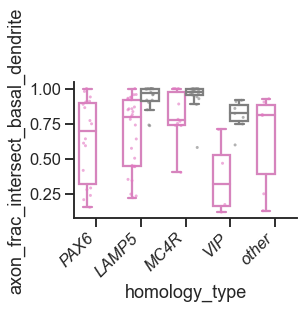

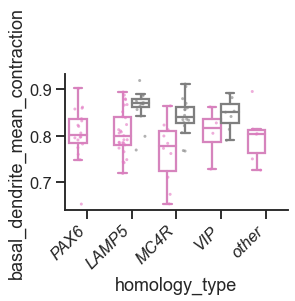

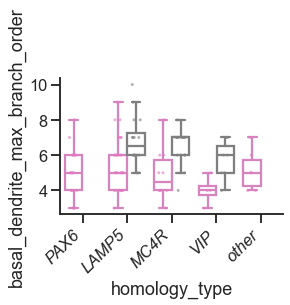

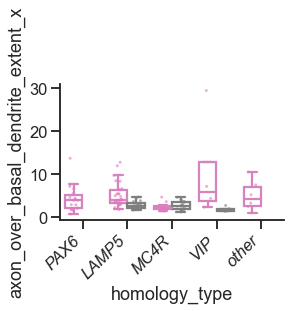

In [59]:
for y in results.index[:7]:
    plot.box_strip(data=combined_morph, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

In [75]:
results = run_species_subclass_stats(combined_l12, morph_features_compare, groups=groups)
# results.query('interaction')
results.head(10)

eta_p_species  pval_species  \
feature                                                           
axon_mean_contraction                    0.561319  4.449685e-18   
basal_dendrite_num_branches              0.380153  1.024290e-10   
axon_frac_above_basal_dendrite           0.356151  4.797508e-10   
axon_frac_intersect_basal_dendrite       0.279216  1.206442e-07   
basal_dendrite_mean_contraction          0.224581  4.276504e-06   
axon_over_basal_dendrite_extent_x        0.213384  7.526231e-06   
basal_dendrite_soma_percentile_x         0.189315  3.122632e-05   
basal_dendrite_max_branch_order          0.172311  8.135475e-05   
axon_max_path_distance                   0.170362  8.185633e-05   
basal_dendrite_extent_x                  0.159431  1.470248e-04   

                                    pval_species:homology_type  rsquared  \
feature                                                                    
axon_mean_contraction                                 0.978314  0.625598   
basal_dendrite_num_branches                           0.563142  0.499941   
axon_frac_above_basal_dendrite                        0.005208  0.559596   
axon_frac_intersect_basal_dendrite                    0.672401  0.371270   
basal_dendrite_mean_contraction                       0.629621  0.261978   
axon_over_basal_dendrite_extent_x                     0.031177  0.348370   
basal_dendrite_soma_percentile_x                      0.171342  0.258056   
basal_dendrite_max_branch_order                       0.672401  0.224082   
axon_max_path_distance                                0.123788  0.321894   
basal_dendrite_extent_x                               0.290009  0.300752   

                                    interaction  sig_groups      PAX6  \
feature                                                                 
axon_mean_contraction                     False         NaN       NaN   
basal_dendrite_num_branches               False         NaN       NaN   
axon_frac_above_basal_dendrite             True  LAMP5, VIP  0.297911   
axon_frac_intersect_basal_dendrite        False         NaN       NaN   
basal_dendrite_mean_contraction           False         NaN       NaN   
axon_over_basal_dendrite_extent_x          True  LAMP5, VIP  0.300000   
basal_dendrite_soma_percentile_x          False         NaN       NaN   
basal_dendrite_max_branch_order           False         NaN       NaN   
axon_max_path_distance                    False         NaN       NaN   
basal_dendrite_extent_x                   False         NaN       NaN   

                                       LAMP5      MC4R       VIP  
feature                                                           
axon_mean_contraction                    NaN       NaN       NaN  
basal_dendrite_num_branches              NaN       NaN       NaN  
axon_frac_above_basal_dendrite      0.000003  0.586729  0.005583  
axon_frac_intersect_basal_dendrite       NaN       NaN       NaN  
basal_dendrite_mean_contraction          NaN       NaN       NaN  
axon_over_basal_dendrite_extent_x   0.000728  0.528978  0.003108  
basal_dendrite_soma_percentile_x         NaN       NaN       NaN  
basal_dendrite_max_branch_order          NaN       NaN       NaN  
axon_max_path_distance                   NaN       NaN       NaN  
basal_dendrite_extent_x                  NaN       NaN       NaN

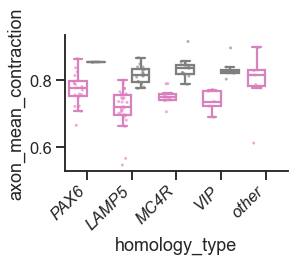

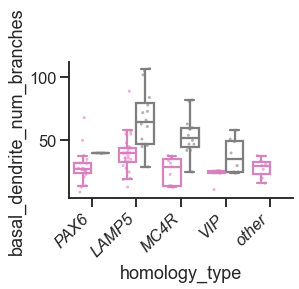

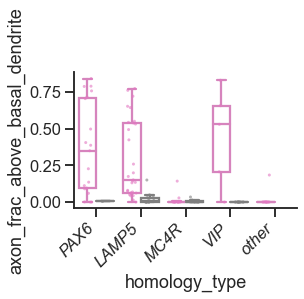

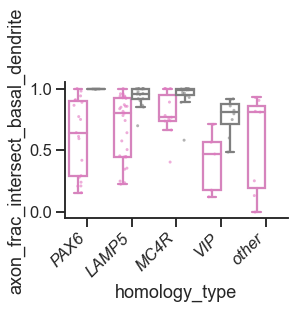

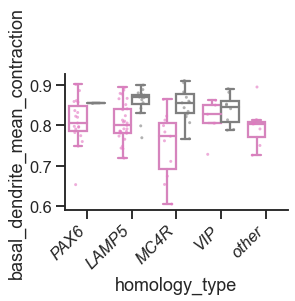

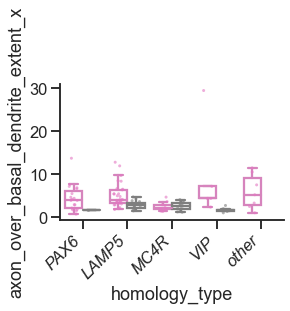

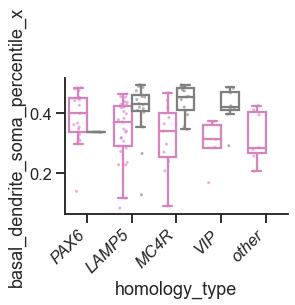

In [76]:
for y in results.index[:7]:
    plot.box_strip(data=combined_l12, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

In [55]:
results = run_species_subclass_stats(combined_morph, morph_features_compare, groups=groups, rank=False)
results.head(10)

eta_p_species  pval_species  \
feature                                                           
axon_mean_contraction                    0.446771  2.468388e-13   
basal_dendrite_num_branches              0.334081  2.180220e-09   
axon_frac_above_basal_dendrite           0.283428  7.107071e-08   
axon_frac_intersect_basal_dendrite       0.228131  2.815427e-06   
basal_dendrite_mean_contraction          0.217408  4.719429e-06   
basal_dendrite_max_branch_order          0.195563  1.728476e-05   
axon_max_path_distance                   0.152780  2.452790e-04   
basal_dendrite_soma_percentile_x         0.138255  5.432527e-04   
axon_over_basal_dendrite_extent_x        0.128789  8.795594e-04   
axon_max_euclidean_distance              0.106623  3.175922e-03   

                                    pval_species:homology_type  rsquared  \
feature                                                                    
axon_mean_contraction                                 0.143745  0.513111   
basal_dendrite_num_branches                           0.191505  0.434694   
axon_frac_above_basal_dendrite                        0.008700  0.444612   
axon_frac_intersect_basal_dendrite                    0.397407  0.311244   
basal_dendrite_mean_contraction                       0.489297  0.290467   
basal_dendrite_max_branch_order                       0.810301  0.266923   
axon_max_path_distance                                0.136152  0.312014   
basal_dendrite_soma_percentile_x                      0.489297  0.191475   
axon_over_basal_dendrite_extent_x                     0.020316  0.273611   
axon_max_euclidean_distance                           0.776697  0.331770   

                                    interaction  sig_groups     LAMP5  \
feature                                                                 
axon_mean_contraction                     False         NaN       NaN   
basal_dendrite_num_branches               False         NaN       NaN   
axon_frac_above_basal_dendrite             True  LAMP5, VIP  0.000002   
axon_frac_intersect_basal_dendrite        False         NaN       NaN   
basal_dendrite_mean_contraction           False         NaN       NaN   
basal_dendrite_max_branch_order           False         NaN       NaN   
axon_max_path_distance                    False         NaN       NaN   
basal_dendrite_soma_percentile_x          False         NaN       NaN   
axon_over_basal_dendrite_extent_x          True  LAMP5, VIP  0.000498   
axon_max_euclidean_distance               False         NaN       NaN   

                                        MC4R       VIP  
feature                                                 
axon_mean_contraction                    NaN       NaN  
basal_dendrite_num_branches              NaN       NaN  
axon_frac_above_basal_dendrite      0.691666  0.001734  
axon_frac_intersect_basal_dendrite       NaN       NaN  
basal_dendrite_mean_contraction          NaN       NaN  
basal_dendrite_max_branch_order          NaN       NaN  
axon_max_path_distance                   NaN       NaN  
basal_dendrite_soma_percentile_x         NaN       NaN  
axon_over_basal_dendrite_extent_x   0.741942  0.008081  
axon_max_euclidean_distance              NaN       NaN

In [17]:
reload(utils)

<module 'ateam.analysis.hivscc_analysis' from '/home/tom.chartrand/work/ateam-tools/ateam/analysis/hivscc_analysis.py'>

### contraction vs branching

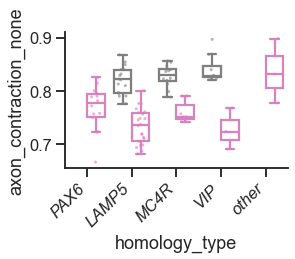

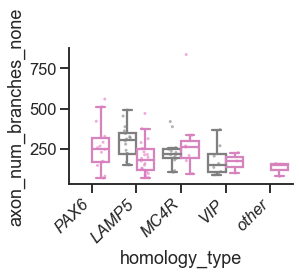

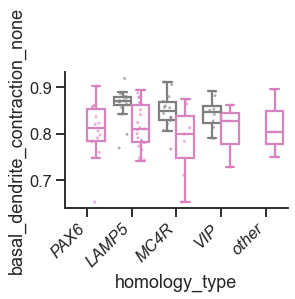

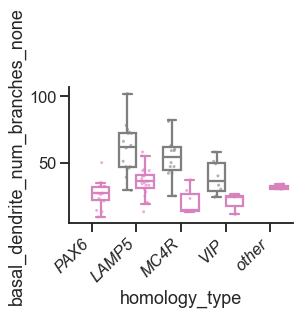

In [37]:
features = [
    'axon_contraction_none',
    'axon_num_branches_none',
    'basal_dendrite_contraction_none',
    'basal_dendrite_num_branches_none',
]
for y in features:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

KeyError: 'PAX6'

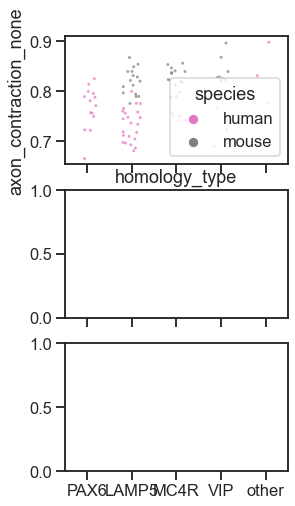

In [20]:
features = [
    'axon_contraction_none',
    'basal_dendrite_num_branches_none',
    'axon_pct_above_basal_dendrite_none',
]
labels = [
    'axon tortuosity',
     "# dendritic branches",
    'axon frac. above dendrites'
]
utils.plot_boxplot_multiple(data=combined, x='homology_type', features=features, hue='species', 
               palette=species_palette,)

Text(0.5, 0, 'subclass')

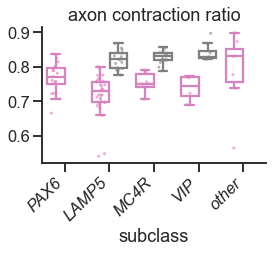

In [48]:
y = "axon_contraction_none"
label = "axon contraction ratio"
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
               palette=species_palette, dodge=True, legend=False, notch=False)
plt.title(label)
plt.ylabel('')
plt.xlabel("subclass")

Text(0.5, 0, 'subclass')

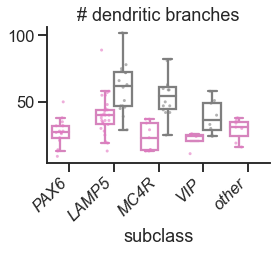

In [49]:
y = "basal_dendrite_num_branches_none"
label = "# dendritic branches"
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
               palette=species_palette, dodge=True, legend=False, notch=False)
plt.title(label)
plt.ylabel('')
plt.xlabel("subclass")

Text(0.5, 0, 'subclass')

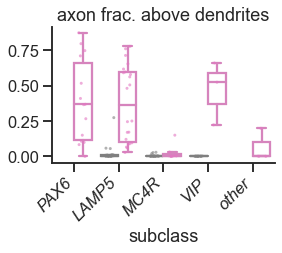

In [27]:
y = "axon_pct_above_basal_dendrite_none"
label = 'axon frac. above dendrites'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
               palette=species_palette, dodge=True, legend=False, notch=False)
plt.title(label)
plt.ylabel('')
plt.xlabel("subclass")

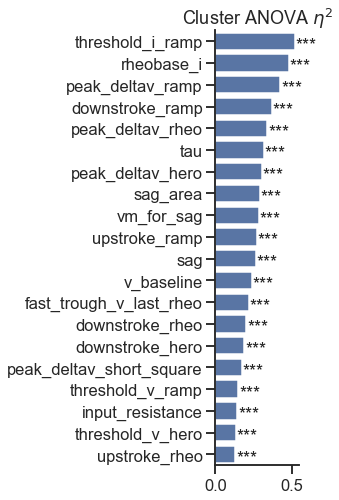

In [30]:
results = utils.run_cluster_anova(combined_all_l1, complete_features, cluster_var='species')

utils.plot_cluster_anova_bar(results, )

In [161]:
reload(plot)

<module 'plotting' from '/allen/programs/celltypes/workgroups/humancolumn_ephysmodeling/tom/projects/ephys_analysis/plotting.py'>

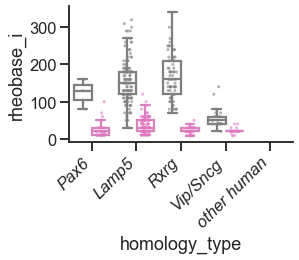

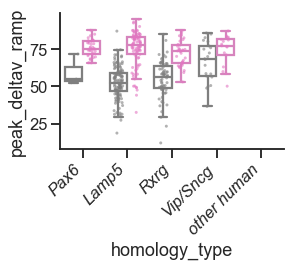

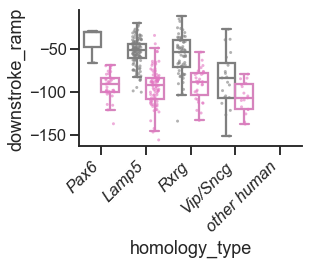

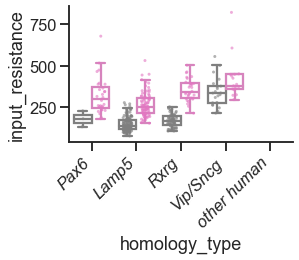

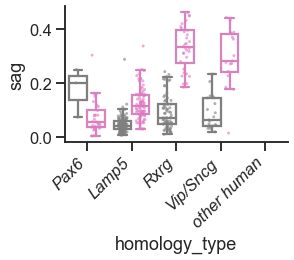

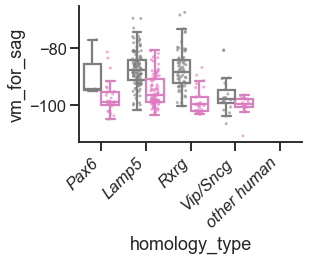

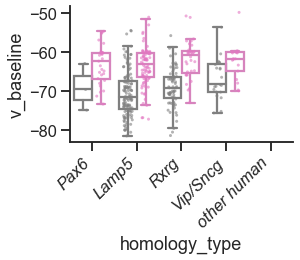

In [19]:
for y in ['rheobase_i', 'peak_deltav_ramp', 'downstroke_ramp', 'input_resistance', 'sag', 'vm_for_sag', 'v_baseline']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

Text(0.5, 0, 'subclass')

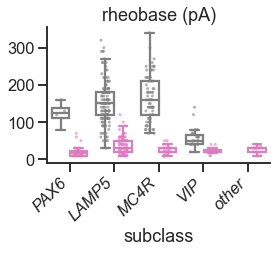

In [29]:
y = "rheobase_i"
label = "rheobase (pA)"
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
               palette=species_palette, dodge=True, legend=False, notch=False)
plt.title(label)
plt.ylabel('')
plt.xlabel("subclass")

Text(0.5, 0, 'subclass')

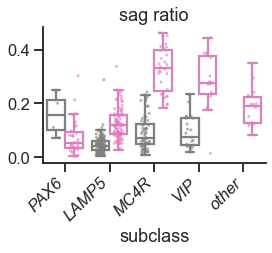

In [31]:
y = "sag"
label = "sag ratio"
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
               palette=species_palette, dodge=True, legend=False, notch=False)
plt.title(label)
plt.ylabel('')
plt.xlabel("subclass")

Text(0.5, 0, 'subclass')

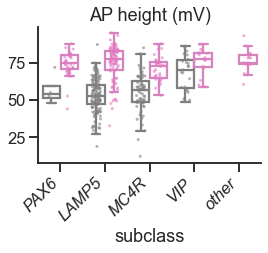

In [30]:
y = "peak_deltav_ramp"
label = "AP height (mV)"
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
               palette=species_palette, dodge=True, legend=False, notch=False)
plt.title(label)
plt.ylabel('')
plt.xlabel("subclass")

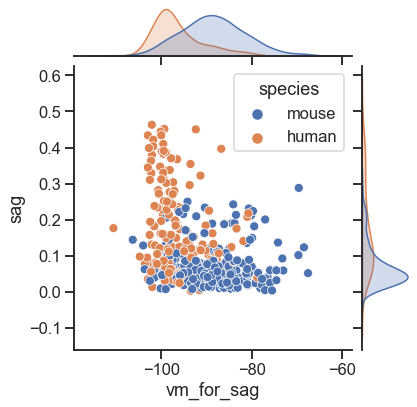

In [27]:
sns.jointplot(x='vm_for_sag',y='sag', data=combined, hue='species')

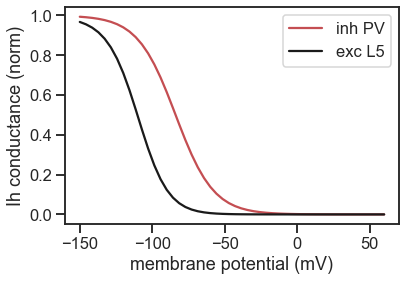

In [74]:
vtrap = lambda x,y: x / (np.exp(x / y) - 1)
mAlpha = lambda v: 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
mBeta  =  lambda v: 0.001*193*np.exp(v/33.1)
ih_amp_exc = lambda v: mAlpha(v)/(mAlpha(v) + mBeta(v))
vm = -83.9
k = 13.1
# A = 1-0.08
A = 1
ih_amp = lambda v: A/(1 + np.exp((v-vm)/k)) + 1-A
v = np.linspace(-150, 60, 50)
plt.plot(v, ih_amp(v), 'r', label='inh PV')
plt.plot(v, ih_amp_exc(v), 'k', label='exc L5')
plt.ylabel('Ih conductance (norm)')
plt.xlabel('membrane potential (mV)')
plt.legend()

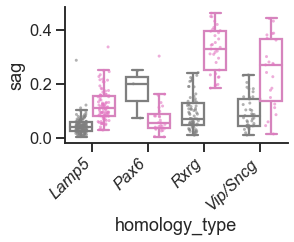

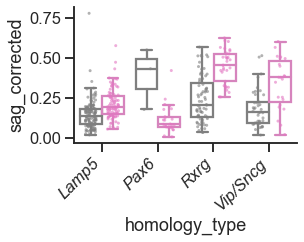

In [75]:
data = combined
fcn = ih_amp
g_base = 1/data.input_resistance
g_sag = g_base / (1-data.sag)
g_sag = g_base + (g_sag - g_base)/(fcn(data.vm_for_sag) - fcn(data.v_baseline))
data['sag_corrected'] = 1 - (g_base/g_sag)
plot.box_strip(data=data, x='homology_type', y='sag', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)
plot.box_strip(data=data, x='homology_type', y='sag_corrected', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)
# plt.ylim(0,5)

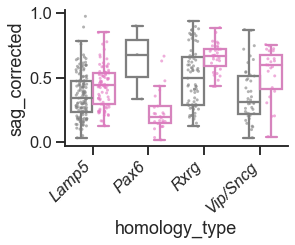

In [69]:
data = combined
fcn = ih_amp_exc
g_base = 1/data.input_resistance
g_sag = g_base / (1-data.sag)
g_sag = g_base + (g_sag - g_base)/(fcn(data.vm_for_sag) - fcn(data.v_baseline))
data['sag_corrected'] = 1 - (g_base/g_sag)
plot.box_strip(data=data, x='homology_type', y='sag_corrected', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

## uniform diffs

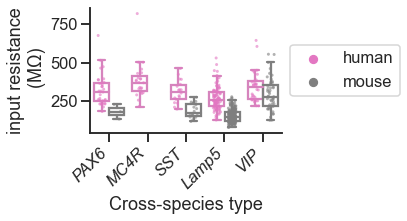

In [164]:
y='input_resistance'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True, 
          order=homology.keys(), figsize=(6,3.4), leg_kws=dict(loc='center left', bbox_to_anchor=(1,0.5)))
plt.ylabel('input resistance\n (MΩ)')
plt.xlabel('Cross-species type')
plt.tight_layout()
plt.gcf().savefig(f'/allen/programs/celltypes/workgroups/humancelltypes/tom/figures/boxplot_{y}.svg')

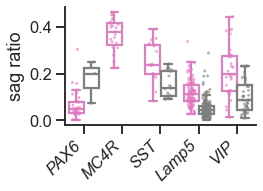

In [165]:
y='sag'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False, 
          order=homology.keys(), figsize=(4,3))
plt.ylabel('sag ratio')
plt.xlabel(None)
plt.tight_layout()
plt.gcf().savefig(f'/allen/programs/celltypes/workgroups/humancelltypes/tom/figures/boxplot_{y}.svg')

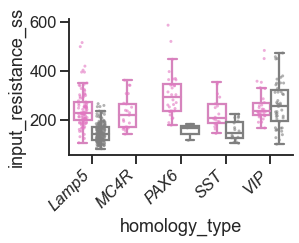

In [170]:
combined.loc[lambda df: df['input_resistance_ss'] > 750, 'input_resistance_ss'] = np.nan
plot.box_strip(data=combined, x='homology_type', y='input_resistance_ss', hue='species', palette=species_palette, dodge=True, legend=False)

In [186]:
import ateam.analysis.plot.sweeps as aplot

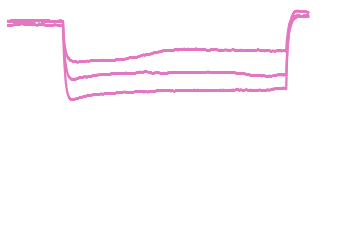

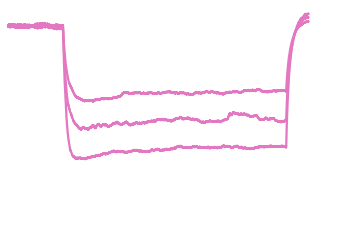

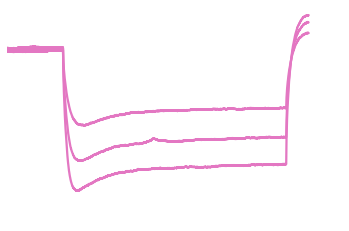

In [453]:
cells = combined.query('species=="human" & homology_type=="Lamp5 SST"').index
for cell in cells[:3]:
    plt.figure()
    aplot.plot_sag(cell, dy=40, scalebar=False, color=species_palette['human'])
    plt.xlim(-0.25,1.25)

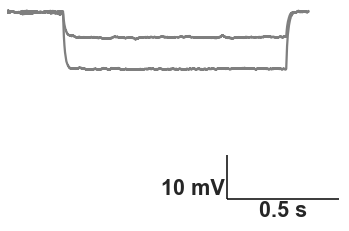

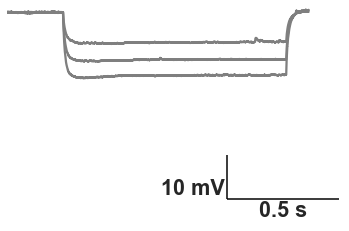

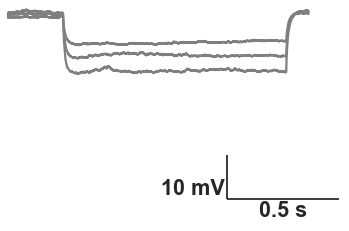

In [454]:
cells = combined.query('species=="mouse" & homology_type=="Lamp5 SST"').index
for cell in cells[:3]:
    plt.figure()
    aplot.plot_sag(cell, dy=50, scalebar=True, color=species_palette['mouse'])
    plt.xlim(-0.25,1.25)

### Lamp5 diffs

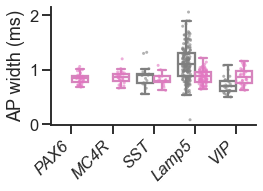

In [186]:
combined['width'] = combined['width_rheo']*1e3
y='width'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False, 
          order=homology.keys(), figsize=(4,3))
plt.ylabel('AP width (ms)')
plt.xlabel(None)
plt.tight_layout()
plt.gcf().savefig(f'/allen/programs/celltypes/workgroups/humancelltypes/tom/figures/boxplot_{y}.svg')

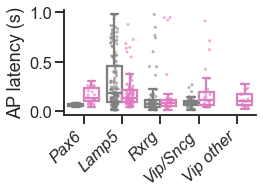

In [79]:
y='latency_rheo'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False, 
          order=homology.keys(), figsize=(4,3))
plt.ylabel('AP latency (s)')
plt.xlabel(None)
plt.tight_layout()
# plt.gcf().savefig(f'/allen/programs/celltypes/workgroups/humancelltypes/tom/figures/boxplot_{y}.svg')

### Schumann types?

Krt73/Fam19a1 as alpha7, Tmem182 (and lamb5 subset?) as canopy?

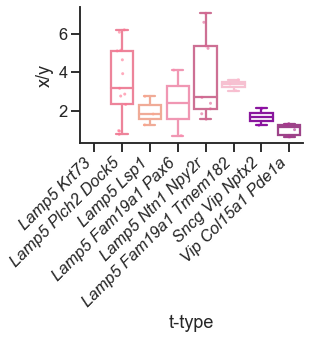

In [23]:
df = mouse_l1.copy()
df['x/y'] = df['axon_extent_x']/df['axon_extent_y']
plot.box_strip(data=df, x=cluster, y='x/y', hue=cluster, palette=palette_mouse, dodge=False)

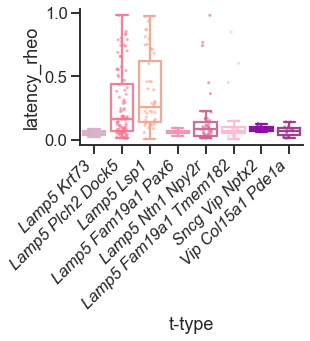

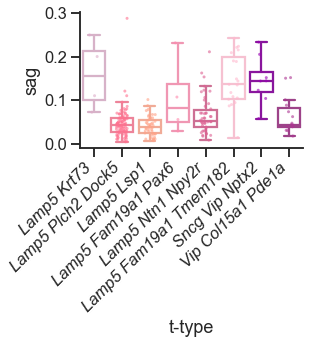

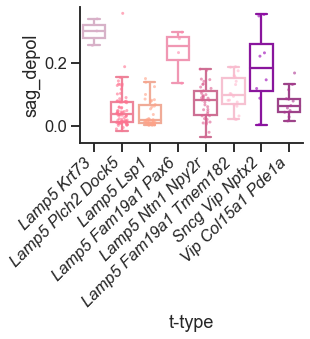

In [19]:
for y in ['latency_rheo', 'sag', 'sag_depol']:
    plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)

### VIP diffs

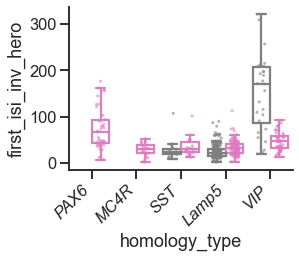

In [106]:
y = 'first_isi_inv_hero'
plot.box_strip(data=combined_all, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False, 
          order=homology.keys(), figsize=(4,3))

### protocol specificity

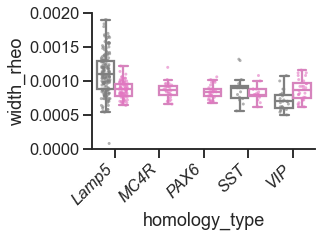

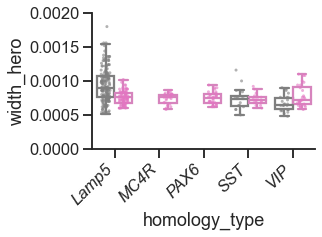

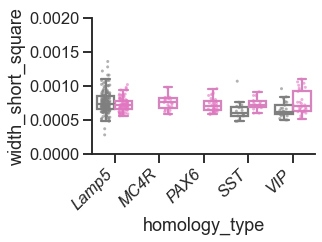

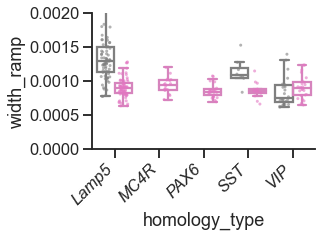

In [188]:
protocols = ['rheo', 'hero', 'short_square', 'ramp']
for y in [f"width_{name}" for name in protocols]:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
    plt.ylim(0,2e-3)
# plt.ylabel('AP width')

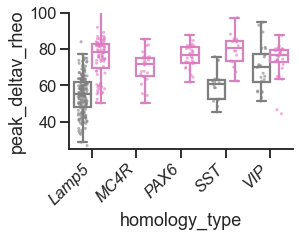

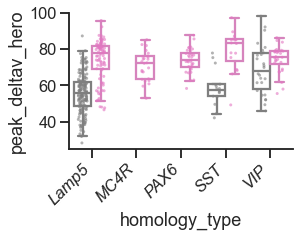

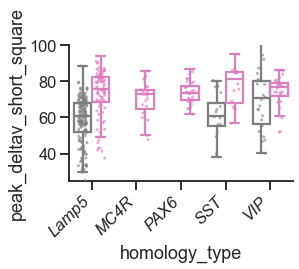

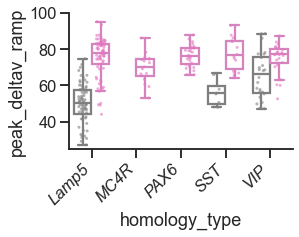

In [189]:
protocols = ['rheo', 'hero', 'short_square', 'ramp']
for y in [f"peak_deltav_{name}" for name in protocols]:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
    plt.ylim(25,100)

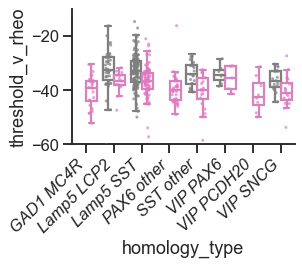

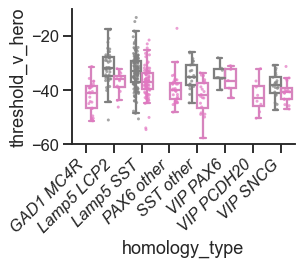

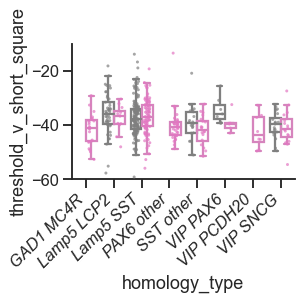

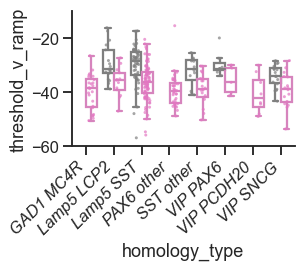

In [577]:
protocols = ['rheo', 'hero', 'short_square', 'ramp']
for y in [f"threshold_v_{name}" for name in protocols]:
    box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
    plt.ylim(-60,-10)

(0.0, 0.2)

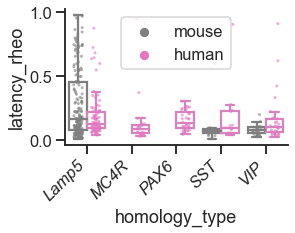

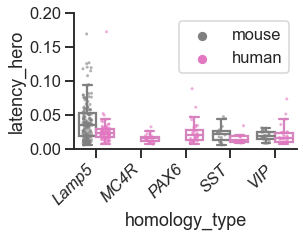

In [190]:
plot.box_strip(data=combined, x='homology_type', y='latency_rheo', hue='species', palette=species_palette, dodge=True, legend=True)
plot.box_strip(data=combined, x='homology_type', y='latency_hero', hue='species', palette=species_palette, dodge=True, legend=True)
plt.ylim(0,0.2)

### Lamp5 ephys details

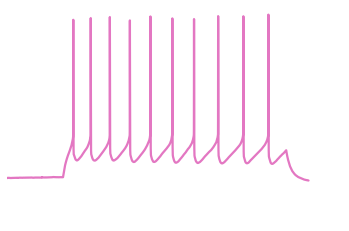

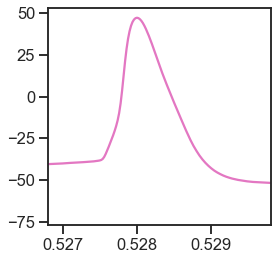

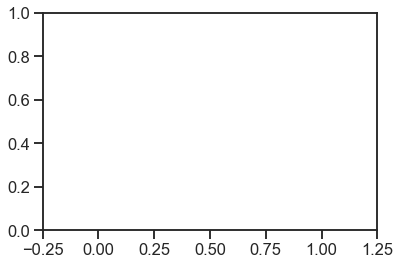

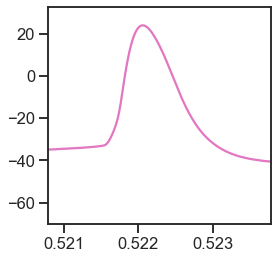

In [456]:
cells = combined.query('species=="human" & homology_type=="Lamp5 LCP2"')
for id, cell in cells.iloc[:2].iterrows():
    plt.figure()
    aplot.plot_hero(id, dy=150, scalebar=False, color=species_palette['human'])
    plt.xlim(-0.25,1.25)
    plot_spike(cell, color=species_palette['human'])
    plt.box('off')

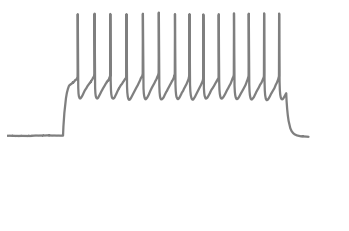

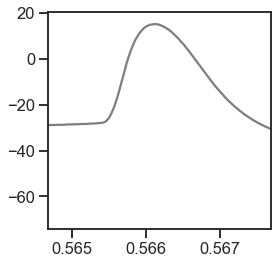

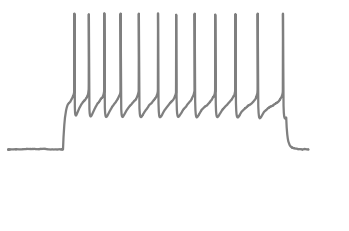

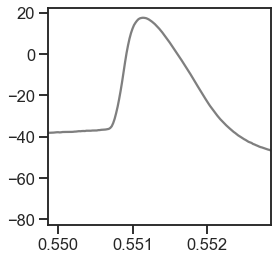

In [457]:
cells = combined.query('species=="mouse" & homology_type=="Lamp5 LCP2"')
for id, cell in cells.iloc[:2].iterrows():
    plt.figure()
    aplot.plot_hero(id, dy=150, scalebar=False, color=species_palette['mouse'])
    plt.xlim(-0.25,1.25)
    plot_spike(cell, color=species_palette['mouse'])
    plt.box('off')

### Lamp5 feature relationships

<AxesSubplot:xlabel='latency_rheo', ylabel='width_rheo'>

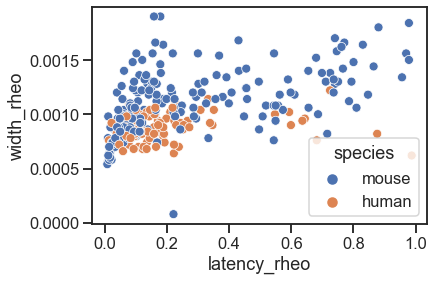

In [350]:
x = 'latency_rheo'
y = 'width_rheo'
cells = combined[combined.homology_type.str.contains('Lamp5')]
sns.scatterplot(data=cells, x=x, y=y, hue='species')

AP width clearly related to latency, maybe also linked to Rin difference

(0.0, 0.2)

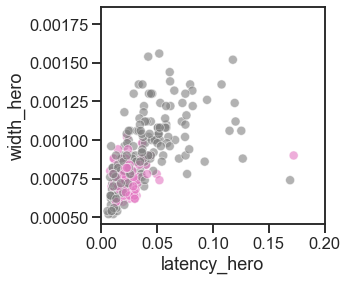

In [252]:
x = 'latency_hero'
y = 'width_hero'
cells = combined[combined.homology_type.str.contains('Lamp5')].sample(frac=1)
plt.figure(figsize=(4,4))
sns.scatterplot(data=cells, x=x, y=y, hue='species', palette=species_palette, legend=False, alpha=0.6)
plt.xlim(0,0.2)

<AxesSubplot:xlabel='input_resistance', ylabel='width_hero'>

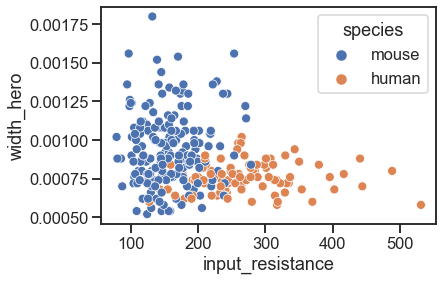

In [356]:
x = 'input_resistance'
y = 'width_hero'
cells = combined[combined.homology_type.str.contains('Lamp5')]
sns.scatterplot(data=cells, x=x, y=y, hue='species')


(0.0, 0.2)

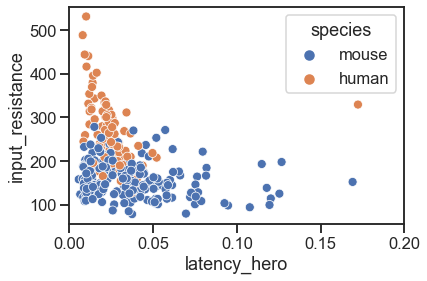

In [358]:
y = 'input_resistance'
x = 'latency_hero'
cells = combined[combined.homology_type.str.contains('Lamp5')]
sns.scatterplot(data=cells, x=x, y=y, hue='species')

plt.xlim(0,0.2)

# Morphology - size diffs

In [172]:
# morph_human = pd.read_csv(
#     "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/human_met_inh_Dec13_features_wide_raw.csv", index_col=0)
# morph_human.columns = [col.replace('_none','') for col in morph_human.columns]
# amorph_human = morph_human.join(human_df, how='inner', rsuffix='_r')

# morph_human = pd.read_csv("../data/L1_All_raw_morphology_features.csv", index_col=1)
# morph_human.columns = [col.replace('_none','') for col in morph_human.columns]
# amorph_human = human_df.join(morph_human, how='inner', rsuffix='_r', on='cell_name')

# morph_human = pd.read_csv("../data/human_aspiny_featuresMay11_2021.csv", index_col=0)
# morph_human = pd.read_excel("../data/L1_aspiny_features_April282021.xlsx", index_col=0)
morph_human = pd.read_excel("../data/human_aspiny_features_withVolumeApril28_2021.xlsx", index_col=1)
morph_human.columns = [col.replace('_none','') for col in morph_human.columns]
# amorph_human = human_df.join(morph_human, how='inner', rsuffix='_r')
# amorph_human = human_df.join(morph_human, how='inner', rsuffix='_r')

morph_mouse = pd.read_csv(
    "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Apr_2020_revisions_features_wide_raw.csv", index_col=0)
morph_mouse.columns = [col.replace('_area','') for col in morph_mouse.columns]
# amorph_mouse = morph_mouse.join(mouse_l1, how='inner')
# amorph_mouse = mouse_df_morph.join(morph_mouse, how='inner')

morph_df = pd.concat([morph_human, morph_mouse], sort=False)
morph_all = combined_all.join(morph_df, lsuffix='_')
morph_l1 = combined.join(morph_df, lsuffix='_')

In [200]:
# mostly deeper t-types missing
shiny_human.loc[morph_human.index.difference(morph_all.index)]

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


exp_component_name layer    batch               cell_name  \
596907611   BT170919-01_E1-50_S48          BT041     H17.03.009.11.08.06   
650077366     SM-GE65Y_S127_E1-50     2  RSC-135     H17.26.003.11.16.04   
665718254     SM-GE91Q_S012_E1-50     3  RSC-146     H18.03.003.11.02.03   
685766680     SM-GE937_S181_E1-50     2  RSC-155     H18.03.008.11.12.01   
685780246     SM-GE937_S184_E1-50     2  RSC-155     H18.03.008.11.12.04   
700801541     SM-GE8X7_S153_E1-50     3  RSC-159  H18.03.012.11.11.01.02   
732115399     SM-GE8YK_S007_E1-50     3  RSC-172  H18.03.314.11.09.01.06   
732127116     SM-GE8YK_S008_E1-50     3  RSC-172  H18.03.314.11.09.01.07   
732141075     SM-GE8YI_S086_E1-50     3  RSC-172  H18.03.314.11.05.01.08   
737159000     SM-GE8YB_S068_E1-50     3  RSC-173  H18.03.315.11.12.01.03   
992386355     SM-J39ZH_S020_E1-50     1  RSC-240     H19.28.018.11.06.04   
1004840721                    NaN   NaN      NaN                     NaN   
1009830462    SM-J2NTQ_S014_E1-50   NaN  RSC-255     H20.28.006.11.08.01   

               spec_id       donor collaborator gender  \
596907611    596907611  H17.03.009          NaN      M   
650077366    650077366  H17.26.003          NaN          
665718254    665718254  H18.03.003          NaN          
685766680    685766680  H18.03.008          NaN      F   
685780246    685780246  H18.03.008          NaN      F   
700801541    700801541  H18.03.012          NaN          
732115399    732115399  H18.03.314          NaN    NaN   
732127116    732127116  H18.03.314          NaN    NaN   
732141075    732141075  H18.03.314          NaN    NaN   
737159000    737159000  H18.03.315          NaN    NaN   
992386355    992386355  H19.28.018        Gabor          
1004840721         NaN         NaN          NaN    NaN   
1009830462  1009830462  H20.28.006        Gabor          

                          collection medical_conditions        postPatch  \
596907611   Patch-seq Pre-production           Epilepsy          No-Seal   
650077366       Patch-seq Production              Tumor  nucleus_present   
665718254       Patch-seq Production           Epilepsy      entire_cell   
685766680       Patch-seq Production           Epilepsy  nucleus_present   
685780246       Patch-seq Production           Epilepsy  nucleus_present   
700801541       Patch-seq Production           Epilepsy  nucleus_present   
732115399       Patch-seq Production           Epilepsy  nucleus_present   
732127116       Patch-seq Production           Epilepsy  nucleus_present   
732141075       Patch-seq Production           Epilepsy  nucleus_present   
737159000       Patch-seq Production           Epilepsy  nucleus_present   
992386355       Patch-seq Production                NaN  nucleus_present   
1004840721                       NaN                NaN              NaN   
1009830462      Patch-seq Production                                 NaN   

           postPatch_classification    filldate rigOperator rigNumber  \
596907611                   No-Seal                                     
650077366           Partial-Nucleus  10/26/2017    lindsayn         7   
665718254               Entire-Cell   1/26/2018    kristenh         2   
685766680                 Nucleated   2/13/2018    lindsayn         1   
685780246                 Nucleated   2/13/2018    lindsayn         1   
700801541                 Nucleated   4/26/2018    lindsayn         2   
732115399                 Nucleated   7/10/2018    lindsayn         7   
732127116                 Nucleated   7/10/2018    lindsayn         7   
732141075                 Nucleated   7/25/2018      rustym         2   
737159000                 Nucleated   7/25/2018    lindsayn         7   
992386355                       NaN                                     
1004840721                      NaN         NaN         NaN       NaN   
1009830462                      NaN         NaN         NaN       NaN   

            cell_depth sliceHealth    patchseq_ro

In [722]:
df = pd.read_csv("/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Apr_2020_revisions_features_wide_raw.csv", index_col=0)
list(df)
df.shape

(520, 46)

In [513]:
list(pd.read_csv(
    "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/human_met_inh_Dec13_features_wide_raw.csv", index_col=0))

['axon_bias_x',
 'axon_bias_y',
 'axon_contraction_none',
 'axon_emd_with_basal_dendrite_none',
 'axon_extent_x',
 'axon_extent_y',
 'axon_hist_pc_0_none',
 'axon_hist_pc_1_none',
 'axon_hist_pc_2_none',
 'axon_hist_pc_3_none',
 'axon_hist_pc_4_none',
 'axon_hist_pc_5_none',
 'axon_max_branch_order_none',
 'axon_max_euclidean_distance_none',
 'axon_max_path_distance_none',
 'axon_num_branches_none',
 'axon_pct_above_basal_dendrite_none',
 'axon_pct_below_basal_dendrite_none',
 'axon_pct_intersect_basal_dendrite_none',
 'axon_soma_distance_none',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_soma_theta_none',
 'axon_total_length_none',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_contraction_none',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_max_branch_order_none',
 'basal_dendrite_max_euclidean_distance_none',
 'basal_dendrite_max_path_distance_none',
 'basal_dendrite_num_branches_none',
 'basal_dendrite_num_stems_none

In [518]:
list(pd.read_csv(
    "../data/L1_All_raw_morphology_features.csv", index_col=0))

['cell_name',
 'Tree_first_cl',
 'axon_bias_x',
 'axon_bias_y',
 'axon_contraction_none',
 'axon_emd_with_basal_dendrite_none',
 'axon_extent_x',
 'axon_extent_y',
 'axon_hist_pc_0_none',
 'axon_hist_pc_1_none',
 'axon_hist_pc_2_none',
 'axon_hist_pc_3_none',
 'axon_hist_pc_4_none',
 'axon_max_branch_order_none',
 'axon_max_euclidean_distance_none',
 'axon_max_path_distance_none',
 'axon_num_branches_none',
 'axon_pct_above_basal_dendrite_none',
 'axon_pct_below_basal_dendrite_none',
 'axon_pct_intersect_basal_dendrite_none',
 'axon_soma_distance_none',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_soma_theta_none',
 'axon_total_length_none',
 'basal_dendrite_average_diameter_none',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_contraction_none',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_hist_pc_0_none',
 'basal_dendrite_hist_pc_1_none',
 'basal_dendrite_hist_pc_2_none',
 'basal_dendrite_hist_pc_3_none',
 'basal_dendr

In [194]:
import plotting as plot
reload(plot)

<module 'plotting' from '/allen/programs/celltypes/workgroups/humancolumn_ephysmodeling/tom/projects/ephys_analysis/plotting.py'>

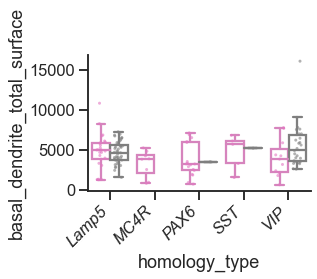

In [203]:
data = morph_all
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_total_surface', hue='species', palette=species_palette, dodge=True)

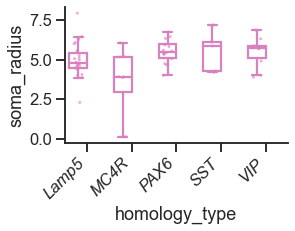

In [176]:
data = morph_l1
plot.box_strip(data=data, x='homology_type', y='soma_radius', hue='species', palette=species_palette, dodge=True)
# plt.ylabel('dend. surf. area')

Text(0, 0.5, 'dend. surf. area')

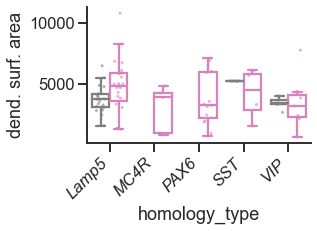

In [222]:
data = morph_l1
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_total_surface', hue='species', palette=species_palette, dodge=True)
plt.ylabel('dend. surf. area')

Text(0, 0.5, 'dend. max dist.')

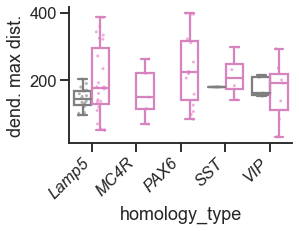

In [223]:
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_max_euclidean_distance', hue='species', palette=species_palette, dodge=True)
plt.ylabel('dend. max dist.')

Text(0, 0.5, 'dend. total length')

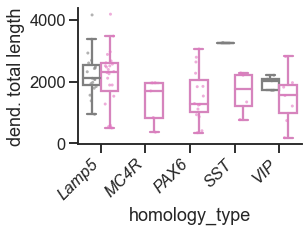

In [224]:
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_total_length', hue='species', palette=species_palette, dodge=True)
plt.ylabel('dend. total length')

Text(0, 0.5, 'dend. # branches')

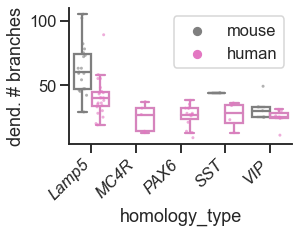

In [225]:
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_num_branches', hue='species', palette=species_palette, dodge=True, legend=True)
plt.ylabel('dend. # branches')

Text(0, 0.5, 'dend. mean radius')

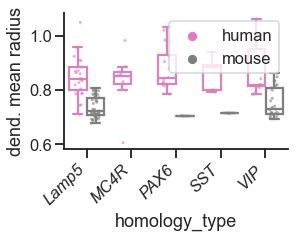

In [209]:
morph_all['mean_radius'] = np.sqrt(morph_all['basal_dendrite_total_surface']/morph_all['basal_dendrite_total_length']/np.pi)
plot.box_strip(data=data, x='homology_type', y='mean_radius', hue='species', palette=species_palette, dodge=True, legend=True)
plt.ylabel('dend. mean radius')

# Cross-type differences comparison

## Combined ANOVA

In [41]:
reload(util)
from util import *

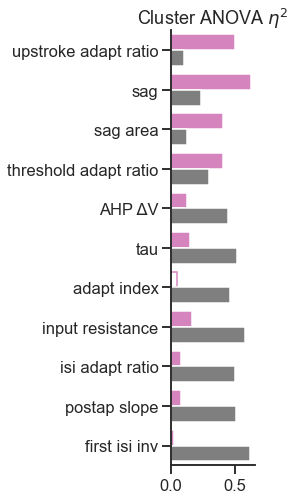

In [8]:

# features = set(ephys_features).difference(['3db_freq_chirp', 'low_freq_impedance_chirp'])
features = complete_features
ylabels = {x:feature_name(x) for x in features}
groups = "homology_type"
# cluster = "topLeaf"
df = combined

figsize=(1.5,8)
nshow=15
rsquared = 'rsquared_adj'
pval=f'pval_{groups}'
cov_type='HC3'
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = utils.run_anova_pairs(df.query("species=='mouse'"), df.query("species=='human'"), 
                                    features, cov_type=cov_type, cluster=groups)

results['rsquared_mean'] = results[rsquared].max(axis=1)
results['rsquared_diff'] = results[(rsquared,'human')] - results[(rsquared,'mouse')]
results_top = results.sort_values('rsquared_mean', ascending=False).iloc[:nshow]
if ylabels is not None:
    results_top = results_top.groupby(feature_name).first().rename_axis('feature')
    nshow = len(results_top)
results_top = results_top.sort_values('rsquared_diff', ascending=False)
data = results_top.loc[:,pval]
stars = data.apply(lambda x: pd.cut(x, [0, 0.001, 0.01, 0.05, 1], labels=['***','**','*',''])).astype(str).values


fig, ax = plt.subplots(figsize=figsize)
bardata = results_top.loc[:,'rsquared'].reset_index().melt(id_vars=['feature'])

palette = species_palette
sns.barplot(data=bardata, y='feature', x='value', hue='variable', palette=palette)
sns.despine()
# if ylabels is not None:
#     ax.set_yticklabels([ylabels[label.get_text()] for label in ax.get_yticklabels()])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('Cluster ANOVA $\eta^2$')
ax.get_legend().remove()

nfeat = nshow
for i, p in enumerate(ax.patches):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    ifeat = i % nfeat
    ispecies = i // nfeat
    annot = stars[ifeat, ispecies]
    if not annot:
        col = p.get_facecolor()
        p.set_edgecolor(col)
        p.set_facecolor('None')
    else:
        space = 0.005
        _x = p.get_x() + p.get_width() + float(space)
        _y = p.get_y() + p.get_height()
#         ax.text(_x, _y, annot, ha="left")

In [40]:
results.sort_values('rsquared_mean', ascending=False).iloc[:nshow]

aic          bic     fvalue      f_pvalue  \
                               human        human      human         human   
feature                                                                      
sag                      -492.640304  -476.074274  66.439736  1.473451e-35   
first_isi_inv_hero       2808.401737  2824.943076   9.517249  4.692444e-07   
input_resistance         2390.865170  2407.406509  11.317058  2.751900e-08   
tau                     -1431.537857 -1414.971827   5.769595  2.061480e-04   
postap_slope_hero         451.379075   467.259823   4.128945  3.211572e-03   
isi_adapt_ratio           997.731983  1014.248508   3.547878  8.064414e-03   
upstroke_adapt_ratio     -386.098290  -369.581765  30.977324  5.483516e-20   
adapt_max                 -58.946689   -42.380659   2.466315  4.626015e-02   
postap_slope_rheo         399.984894   415.865643   2.982683  2.057303e-02   
trough_deltav_hero       1347.014591  1363.580621  12.278767  6.142008e-09   
fast_trough_deltav_hero  1114.422786  1130.964124  12.417362  5.015714e-09   

                                 llf  rsquared rsquared_adj   nobs  \
                               human     human        human  human   
feature                                                              
sag                       251.320152  0.627413     0.619886  203.0   
first_isi_inv_hero      -1399.200869  0.019723    -0.000181  202.0   
input_resistance        -1190.432585  0.162483     0.145477  202.0   
tau                       720.768928  0.150437     0.133274  203.0   
postap_slope_hero        -220.689537  0.075622     0.054125  177.0   
isi_adapt_ratio          -493.865992  0.077352     0.058522  201.0   
upstroke_adapt_ratio      198.049145  0.501897     0.491731  201.0   
adapt_max                  34.473344  0.048477     0.029254  203.0   
postap_slope_rheo        -194.992447  0.078050     0.056610  177.0   
trough_deltav_hero       -668.507296  0.127159     0.109526  203.0   
fast_trough_deltav_hero  -552.211393  0.217111     0.201215  202.0   

                        pval_homology_type fval_homology_type  \
                                     human              human   
feature                                                         
sag                           1.267167e-33          66.439736   
first_isi_inv_hero            1.921667e-06           9.517249   
input_resistance              1.245597e-07          11.317058   
tau                           4.432183e-04           5.769595   
postap_slope_hero             5.415591e-03           4.128945   
isi_adapt_ratio               1.238464e-02           3.547878   
upstroke_adapt_ratio          1.571941e-18          30.977324   
adapt_max                     5.603342e-02           2.466315   
postap_slope_rheo             2.757196e-02           2.982683   
trough_deltav_hero            4.063174e-08          12.278767   
fast_trough_deltav_hero       3.921376e-08          12.417362   

                        eta_p_homology_type eta_p_Residual          model  \
                                      human          human          human   
feature                                                                     
sag                                0.573054            0.5  homology_type   
first_isi_inv_hero                 0.161948            0.5  homology_type   
input_resistance                   0.186852            0.5  homology_type   
tau                                0.104390            0.5  homology_type   
postap_slope_hero                  0.087610            0.5  homology_type   
isi_adapt_ratio                    0.067517            0.5  homology_type   
upstroke_adapt_ratio               0.387326            0.5  homology_type   
adapt_max                          0.047460            0.5  homology_type   
postap_slope_rheo                  0.064865            0.5  homology_type   
trough_deltav_hero                 0.198754            0.5  homology_type   
fast_trough_deltav_hero            0.201360    

upstroke_adapt_ratio


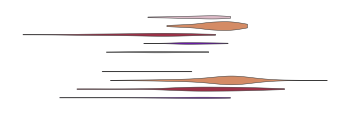

threshold_v_adapt_ratio


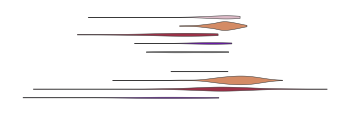

tau


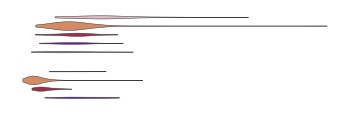

first_isi_inv_hero


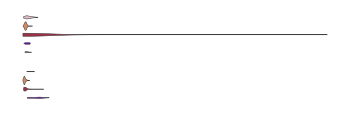

adapt_max


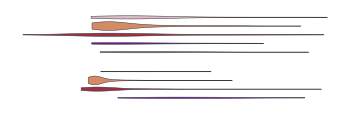

In [10]:
feats = ['upstroke_adapt_ratio', 
         'threshold_v_adapt_ratio', 
         'tau',
         'first_isi_inv_hero',
        'adapt_max']
for feat in feats:
    print(feat)
    fig, ax = plt.subplots(figsize=(6,2))
    sns.violinplot(data=combined, x=feat, y='species', hue='homology_type', cut=0,
                   legend=False, palette=palette_subclass, scale='count', scale_hue=True,
                  inner=None, linewidth=0.5, dodge=True, ax=ax,)
    plt.legend().remove()
    ax.axis('off')
    plt.show()

### Boxplots from ANOVA feats

(0.0, 25.0)

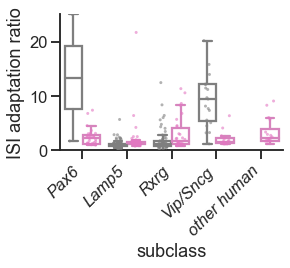

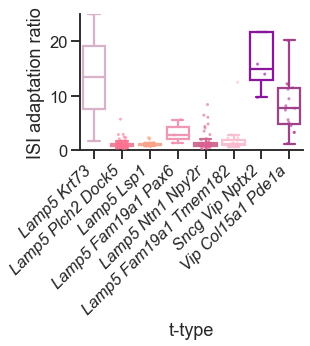

In [57]:
y = 'isi_adapt_ratio'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylim(0,25)
plt.ylabel('ISI adaptation ratio')
plt.xlabel('subclass')
plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)
plt.ylabel('ISI adaptation ratio')
plt.ylim(0,25)

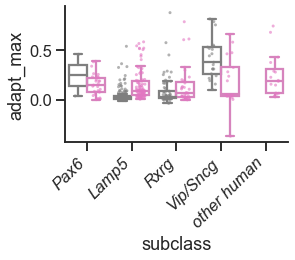

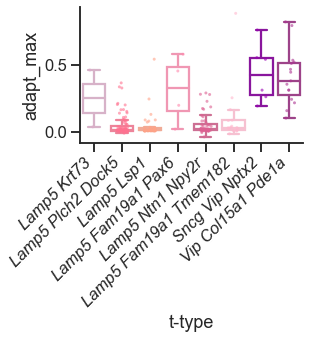

In [56]:
y = 'adapt_max'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
# plt.ylim(0,25)
# plt.ylabel('ISI adaptation ratio')
plt.xlabel('subclass')
plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)
# plt.ylabel('ISI adaptation ratio')
# plt.ylim(0,25)

In [171]:
import matplotlib
def plot_type(ttype, feature, plot_fcn, species, ttype_color=True, ax=None, stimulus="Long Square"):
    cells = combined.loc[combined[cluster]==ttype] 
    cell = (cells[feature] - cells[feature].median()).abs().argmin()
    dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True, sweeps_query=None, stimulus=stimulus)
    plt.sca(ax)
    if not ttype_color:
        color = species_palette[species]
    else:
        color = palette_subclass[combined.loc[cell, 'homology_type']]
        if combined.loc[cell, 'species']=='mouse':
            color = np.array(matplotlib.colors.to_rgb(color))
            color = (color + 2*color.mean()*np.ones(3))/2.5
    plot_fcn(dataset, sweeps, color=color)
    
def plot_5spike(dataset, sweeps, color):
    sweepset = dataset.sweep_set(sweeps.query('num_spikes >= 5').sort_values('num_spikes')["sweep_number"].values[0])
    ps.plot_sweeps_thumb(sweepset, color=color)

def plot_comparison(types_dict, feature, plot_fcn, n_types=2, stimulus="Long Square"):
    fig, axes = plt.subplots(2,n_types, figsize=(4*n_types,6), squeeze=False)
    for i, (species, ttypes) in enumerate(types_dict.items()):
        for j, ttype in enumerate(ttypes):
            plot_type(ttype, feature, plot_fcn, species=species, ttype_color=n_types>1, ax=axes[i,j], stimulus=stimulus)
            if j==0:
                plt.axis('on')
                plt.box(False)
                axes[i,j].set_ylabel(species)
                axes[i,j].set_yticks([])
                axes[i,j].get_xaxis().set_visible(False)
            if i==0 and n_types>1:
                axes[i,j].set_title(homology_mapping_human[ttype] if species=='human' else homology_mapping_mouse[ttype])
                

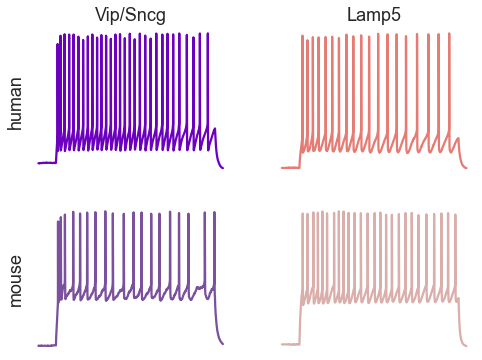

In [122]:
types_dict = {
    'human':[
    'VIP TSPAN12',
    'SST NMBR'
    ],
    'mouse':[
    'Sncg Vip Nptx2',
    'Lamp5 Plch2 Dock5',
    ],
}
feature, plot_fcn = 'isi_adapt_ratio', plot_5spike
plot_comparison(types_dict, feature, plot_fcn)

Text(0.5, 0, 'subclass')

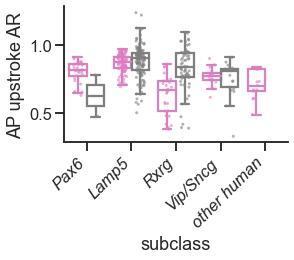

In [95]:
y = 'upstroke_adapt_ratio'
ylabel = 'AP upstroke AR'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')

Text(0, 0.5, 'AP upstroke AR')

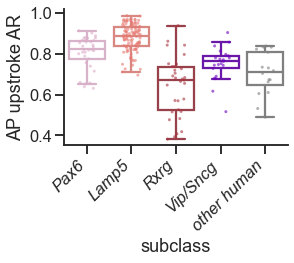

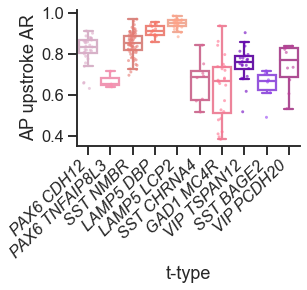

In [97]:
plot.box_strip(data=human_df, x='homology_type', y=y, palette=palette_subclass,legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')
plot.box_strip(data=human_df, x=cluster, y=y, palette=palette_human)
plt.ylabel(ylabel)

Text(0.5, 0, 'subclass')

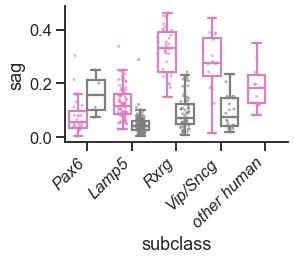

In [99]:
y = 'sag'
ylabel = y
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')

Text(0, 0.5, 'sag')

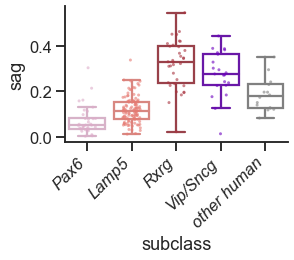

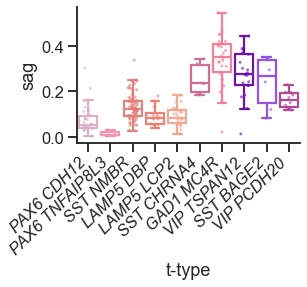

In [100]:
plot.box_strip(data=human_aibs, x='homology_type', y=y, palette=palette_subclass,legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')
plot.box_strip(data=human_aibs, x=cluster, y=y, palette=palette_human)
plt.ylabel(ylabel)

In [147]:
reload(ps)

<module 'ateam.analysis.plot.sweeps' from '/home/tom.chartrand/work/ateam-tools/ateam/analysis/plot/sweeps.py'>

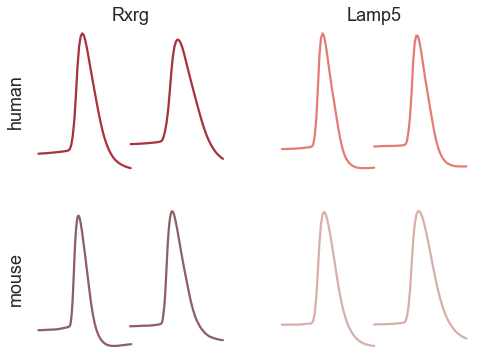

In [150]:
def plot_spike_adapt(dataset, sweeps, color):
    sweep = dataset.sweep(sweeps.query('num_spikes >= 5').sort_values('num_spikes')["sweep_number"].values[0])
    ps.plot_sweep_spikes(sweep, nspikes=[0,3], color=color)
#     plt.xlim(t0-1e-3, t0+0.02)
    
types_dict = {
    'human':[
    'SST CHRNA4',
    'SST NMBR'
    ],
    'mouse':[
    'Lamp5 Fam19a1 Tmem182',
    'Lamp5 Plch2 Dock5',
    ],
}
feature, plot_fcn = 'upstroke_adapt_ratio', plot_spike_adapt
plot_comparison(types_dict, feature, plot_fcn)

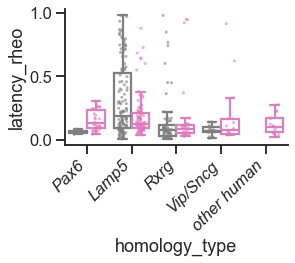

In [86]:
# could support idea of more human diversity in Pax6/Rxrg, more mouse in Sncg/Lamp5
y = 'latency_rheo'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)

### Morpho

Text(0.5, 0, 'human t-type')

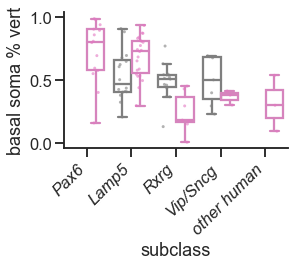

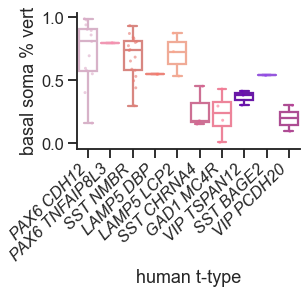

In [67]:
y = 'basal_dendrite_soma_percentile_y'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel('basal soma % vert')
plt.xlabel('subclass')
plot.box_strip(data=human_l1, x=cluster, y=y, hue=cluster, palette=palette_human, dodge=False)
plt.ylabel('basal soma % vert')
plt.xlabel('human t-type')

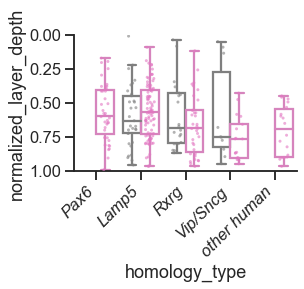

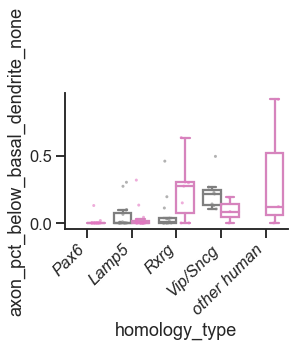

In [80]:
y = 'normalized_layer_depth'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylim([1,0])

y = 'axon_pct_below_basal_dendrite_none'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)

Text(0.5, 0, 'mouse t-type')

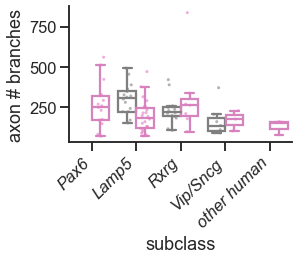

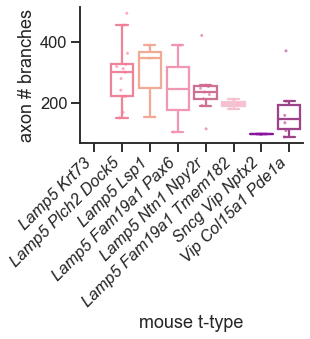

In [65]:
y = 'axon_num_branches_none'
name = 'axon # branches'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel(name)
plt.xlabel('subclass')
plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)
plt.ylabel(name)
plt.xlabel('mouse t-type')

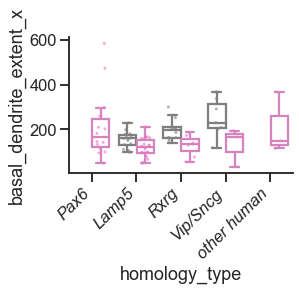

In [81]:
y = 'basal_dendrite_extent_x'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)

### Uniform diffs

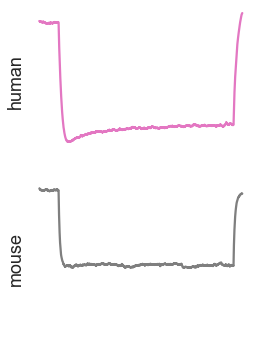

In [170]:
types_dict = {
    'human':[
    'SST NMBR'
    ],
    'mouse':[
    'Lamp5 Plch2 Dock5',
    ],
}
def plot_spike_adapt(dataset, sweeps, color):
    sweeps = sweeps.set_index('sweep_number')
    sweep = (sweeps['stimulus_amplitude'] - -40).abs().argsort().values[0]
    ps.plot_sweeps_thumb(dataset.sweep_set([sweep]), color=color, dy=30)
    
feature, plot_fcn = 'input_resistance', plot_spike_adapt
plot_comparison(types_dict, feature, plot_fcn, n_types=1)

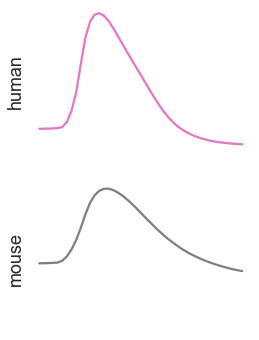

In [179]:
def plot_first_spike(dataset, sweeps, color):
    sweep = sweeps["sweep_number"].values[0]
    ps.plot_sweep_spikes(dataset.sweep(sweep), color=color, dy=100, pre=0.2, scalebar=False)
    
feature, plot_fcn = 'peak_deltav_ramp', plot_first_spike
plot_comparison(types_dict, feature, plot_fcn, n_types=1, stimulus="Ramp")

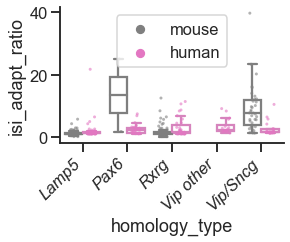

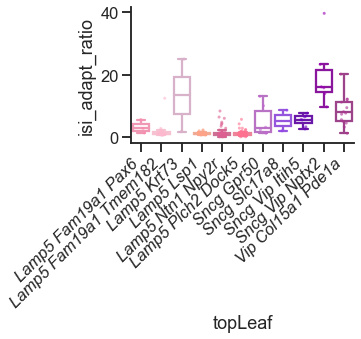

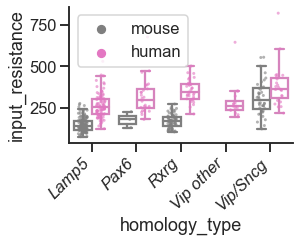

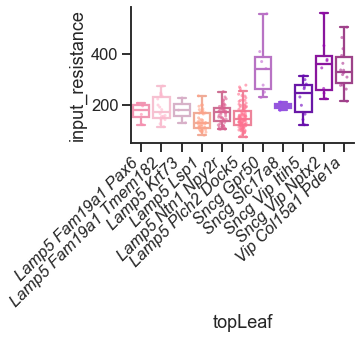

In [83]:
combined.loc[lambda df: df['input_resistance'] > 1000, 'input_resistance'] = np.nan
for y in ['isi_adapt_ratio', 'input_resistance']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)
    plot.box_strip(data=mouse_l1, x='topLeaf', y=y, hue='topLeaf', palette=palette_mouse, dodge=False)

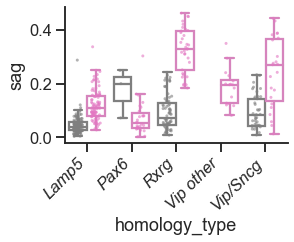

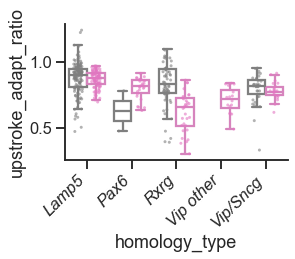

In [85]:
for y in ['sag', 'upstroke_adapt_ratio']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
#     plot.box_strip(data=human_aibs, x='topLeaf', y=y, hue='topLeaf', palette=palette_human, dodge=False)

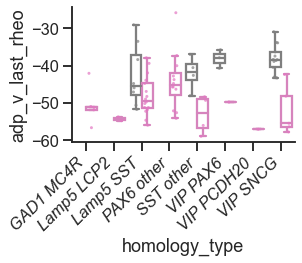

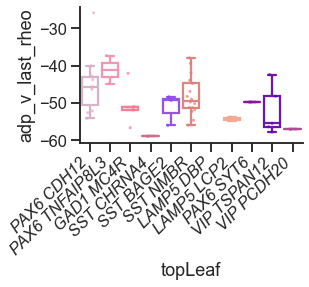

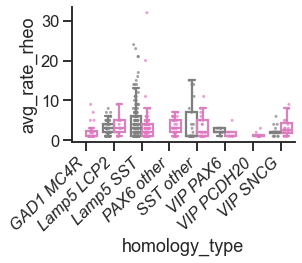

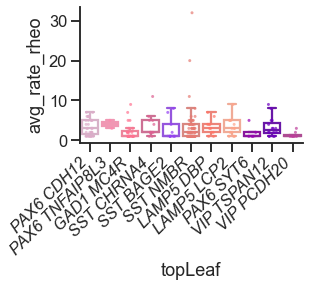

In [717]:
for y in ['adp_v_last_rheo', 'avg_rate_rheo']:
    box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
    box_strip(data=human_aibs, x='topLeaf', y=y, hue='topLeaf', palette=palette_human, dodge=False)

In [ ]:
y = 'isi_adapt_ratio'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)

### sag related props

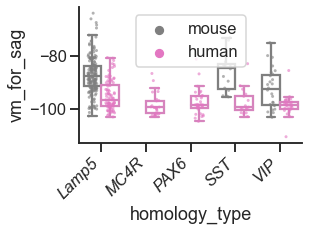

In [366]:
y = 'vm_for_sag'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)

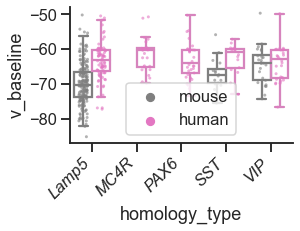

In [371]:
y = 'v_baseline'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)

# Spike shapes

In [19]:
from ipfx.dataset.create import create_ephys_data_set
from ipfx.qc_feature_extractor import sweep_qc_features
from ipfx.lims_queries import get_nwb_path_from_lims
import allensdk.core.json_utilities as ju
import logging

def plot_sweep(cell, sweep_name='hero', **kwargs):
    source = 'tamas' if cell.get('collaborator')=='Gabor' else 'aibs' if cell.get('species')!='mouse' else 'aibs_mouse'
    id = cell.sample_id if source=='tamas' else cell.spec_id
    output_path = f"/home/tom.chartrand/projects/data/u01/{source}/output/{id}/output.json"

    nwb_path = f"/home/tom.chartrand/projects/data/u01/{source}/converted/{id}.nwb"
    nwb_path = nwb_path if source=='tamas' else get_nwb_path_from_lims(int(id))
    data_set = create_ephys_data_set(nwb_path)

    output = ju.read(output_path)
    hero_rec = output['feature_extraction']['cell_features']['long_squares'][f'{sweep_name}_sweep']
    sweep = data_set.sweep(hero_rec['sweep_number'])
    sweep.align_to_start_of_epoch('experiment')
    sweep.select_epoch('experiment')

    plt.figure()
    plt.plot(sweep.t, sweep.v, **kwargs)
    
def plot_spike(cell, i_spike=0, sweep_name='hero', **kwargs):
    source = 'tamas' if cell.get('collaborator')=='Gabor' else 'aibs' if cell.get('species')!='mouse' else 'aibs_mouse'
    id = cell.sample_id if source=='tamas' else cell.spec_id
    output_path = f"/home/tom.chartrand/projects/data/u01/{source}/output/{id}/output.json"

    nwb_path = f"/home/tom.chartrand/projects/data/u01/{source}/converted/{id}.nwb"
    nwb_path = nwb_path if source=='tamas' else get_nwb_path_from_lims(int(id))
    data_set = create_ephys_data_set(nwb_path)

    output = ju.read(output_path)
    hero_rec = output['feature_extraction']['cell_features']['long_squares'][f'{sweep_name}_sweep']
    sweep = data_set.sweep(hero_rec['sweep_number'])
    sweep.align_to_start_of_epoch('experiment')
    sweep.select_epoch('experiment')

    upstroke_i = hero_rec['spikes'][i_spike]['upstroke_index']
    upstroke_t = hero_rec['spikes'][i_spike]['upstroke_t']
    plt.figure(figsize=(4,4))
    plt.plot(sweep.t, sweep.v, **kwargs)
#     plt.plot([upstroke_t,upstroke_t], [-50, 50])
    plt.xlim(upstroke_t - 10e-4, upstroke_t + 20e-4)
    
def plot_tp(cell, sweep_name='hero'):
    source = 'tamas' if cell.get('collaborator')=='Gabor' else 'aibs' if cell.get('species')!='mouse' else 'aibs_mouse'
    id = cell.sample_id if source=='tamas' else cell.spec_id
    output_path = f"/home/tom.chartrand/projects/data/u01/{source}/output/{id}/output.json"

    nwb_path = f"/home/tom.chartrand/projects/data/u01/{source}/converted/{id}.nwb"
    nwb_path = nwb_path if source=='tamas' else get_nwb_path_from_lims(int(id))
    data_set = create_ephys_data_set(nwb_path)
    
    output = ju.read(output_path)
    hero_rec = output['feature_extraction']['cell_features']['long_squares'][f'{sweep_name}_sweep']
    sweep = data_set.sweep(hero_rec['sweep_number'])
    plt.figure(figsize=(4,4))
    i_start = np.flatnonzero(sweep.i!=0)[0]
    dt = sweep.t[1] - sweep.t[0]
    window = slice(i_start,i_start+int(50e-3/dt))
    plt.plot(sweep.t[window], sweep.v[window], '-b.')
#     plt.xlim((t_start-5)*1e-3, (t_start+15)*1e-3)

(0.0, 0.0001)

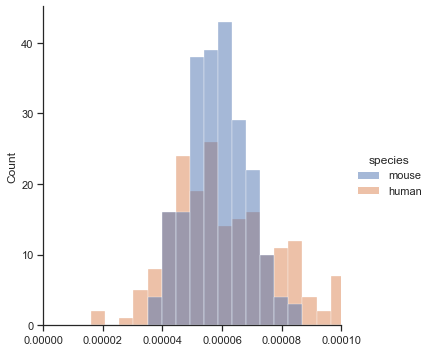

In [127]:
sns.displot(data=combined, x=combined['tau']/combined['input_resistance'], hue='species')
plt.xlim(0, 1e-4)

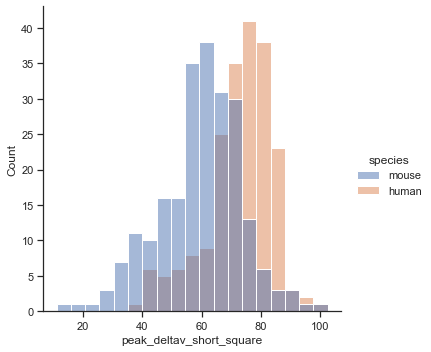

In [80]:
sns.displot(data=combined, x='peak_deltav_short_square', hue='species')

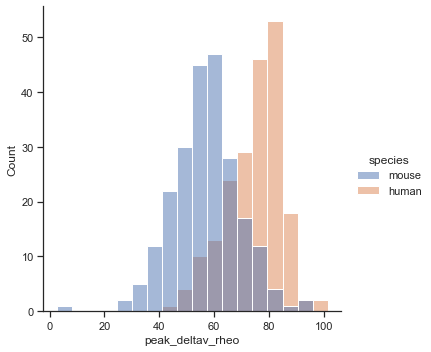

In [78]:
sns.displot(data=combined, x='peak_deltav_rheo', hue='species')

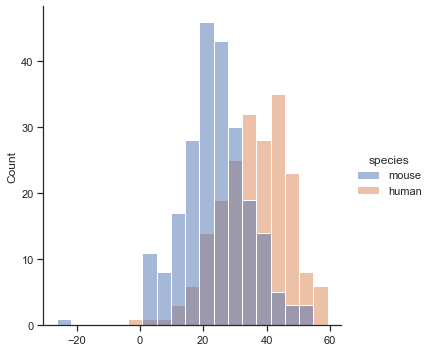

In [128]:
sns.displot(data=combined, x=combined['peak_deltav_rheo']+combined['threshold_v_rheo'], hue='species')

(0.0, 1000.0)

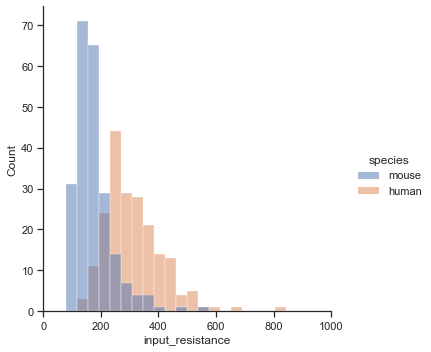

In [97]:
sns.displot(data=combined, x='input_resistance', hue='species')
plt.xlim(0,1000)

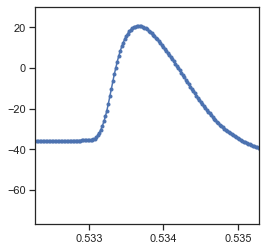

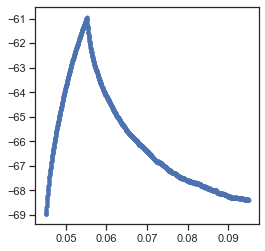

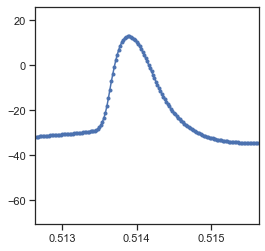

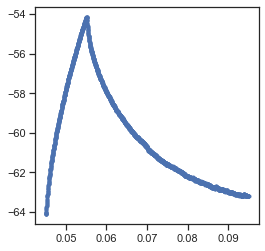

In [88]:
cells = mouse_l1.query(f'peak_deltav_short_square<40').sample(frac=1)
for i, cell in cells.iloc[:2].iterrows():
    try:
        plot_spike(cell)
        plot_tp(cell)
    except Exception:
        logging.exception("plotting failed")

(0.0, 2.0)

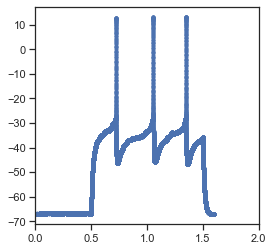

In [93]:
plot_spike(cell, sweep_name='rheobase')
plt.xlim(0.5, 1.5)

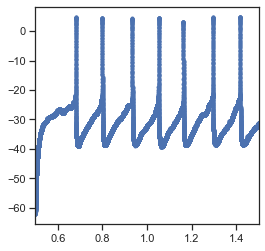

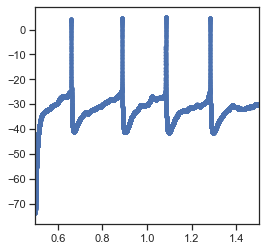

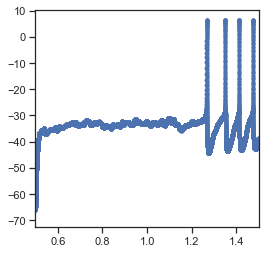

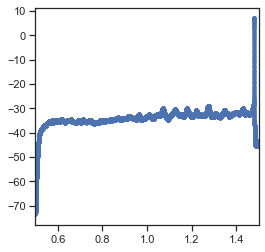

In [95]:
cells = mouse_l1.query(f'peak_deltav_rheo<40').sample(frac=1)
for i, cell in cells.iloc[:4].iterrows():
    try:
        plot_spike(cell, sweep_name='rheobase')
        plt.xlim(0.5, 1.5)
#         plot_tp(cell)
    except Exception:
        logging.exception("plotting failed")

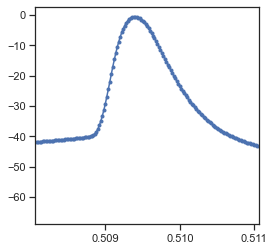

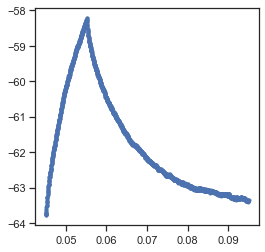

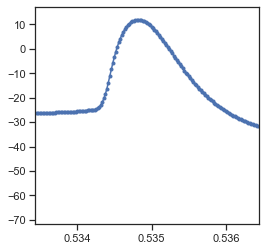

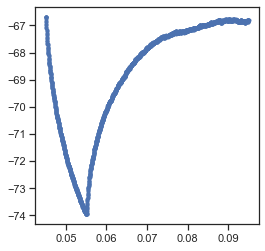

In [90]:
cells = mouse_l1.query(f'peak_deltav_hero<40').sample(frac=1, random_state=0)
for i, cell in cells.iloc[:2].iterrows():
    try:
        plot_spike(cell)
        plot_tp(cell)
    except Exception:
        logging.exception("plotting failed")

ERROR:root:plotting failed
Traceback (most recent call last):
  File "<ipython-input-91-d86d5650f0ab>", line 4, in <module>
    plot_spike(cell, i_spike=3)
  File "<ipython-input-85-2c5d4ecf19a4>", line 22, in plot_spike
    upstroke_i = hero_rec['spikes'][i_spike]['upstroke_index']
IndexError: list index out of range


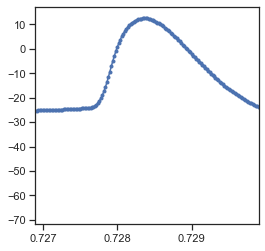

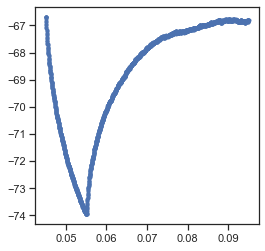

In [91]:
cells = mouse_l1.query(f'peak_deltav_hero<40').sample(frac=1, random_state=0)
for i, cell in cells.iloc[:2].iterrows():
    try:
        plot_spike(cell, i_spike=3)
        plot_tp(cell)
    except Exception:
        logging.exception("plotting failed")

### spike shape diffs - cap comp?

In [ ]:
import ipfx.bin.features_from_output_json as features

workdir = "/home/tom.chartrand/projects/data/u01/"
aibs_files = [os.path.join(workdir, f"aibs/output/{id}/output.json") for id in human_aibs.index]
mouse_files = [os.path.join(workdir, f"aibs_mouse/output/{id}/output.json") for id in mouse_l1.index]

sweep_qc_df = features.process_file_list(aibs_files+mouse_files, fcn=features.extract_sweep_qc_info)

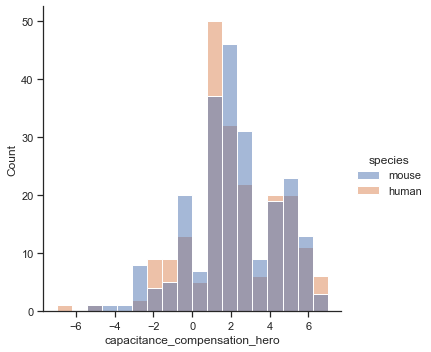

In [118]:
sweep_qc_df.index = list(human_aibs.index) + list(mouse_l1.index)

qc_df = combined.join(sweep_qc_df, how='inner')
sns.displot(qc_df, x='capacitance_compensation_hero', hue='species')

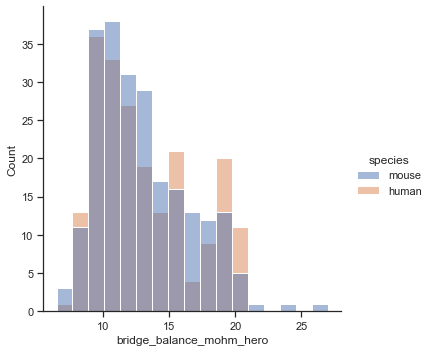

In [120]:
sns.displot(qc_df, x='bridge_balance_mohm_hero', hue='species')

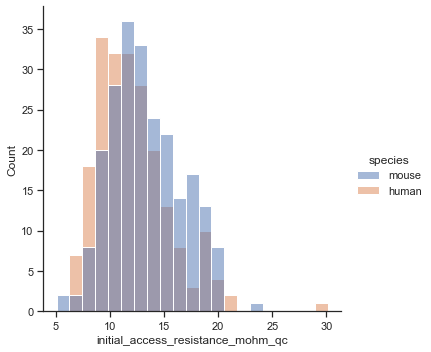

In [121]:
sns.displot(qc_df, x='initial_access_resistance_mohm_qc', hue='species')

## Mouse only ANOVA

In [54]:
# cluster_var = 'seurat_cluster'
cluster_var = 'topLeaf'

complete_df = mouse_l1

sig_clusters = (complete_df[cluster_var].value_counts().loc[lambda x: x>=5])

complete_df['cluster_plot'] = complete_df[cluster_var].astype(ttypes_mouse)
# complete_df.cluster_plot.cat.add_categories(['other'], inplace=True)
# complete_df.loc[lambda df: ~df[cluster_var].isin(sig_clusters.index), 'cluster_plot'] = 'other'
complete_df.cluster_plot.cat.remove_unused_categories(inplace=True)
complete_df.cluster_plot.value_counts()

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Lamp5 Plch2 Dock5        90
Lamp5 Ntn1 Npy2r         50
Lamp5 Lsp1               41
Vip Col15a1 Pde1a        16
Lamp5 Fam19a1 Tmem182    16
Sncg Vip Itih5            7
Sncg Gpr50                7
Sncg Vip Nptx2            6
Lamp5 Fam19a1 Pax6        4
Lamp5 Krt73               3
Sncg Slc17a8              2
Name: cluster_plot, dtype: int64

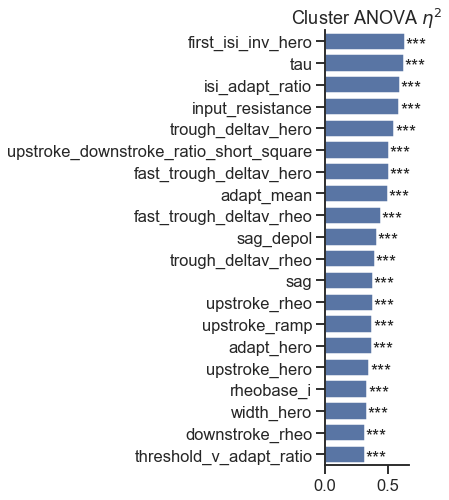

In [56]:
anova_df = complete_df[complete_df[cluster_var].isin(sig_clusters.index)]
anova_df.cluster_plot.cat.remove_unused_categories(inplace=True)
# workaround patsy bug with number in name
results = utils.run_cluster_anova(anova_df, set(complete_features).difference(['3db_freq_chirp']), cluster_var='cluster_plot')

utils.plot_cluster_anova_bar(results, )

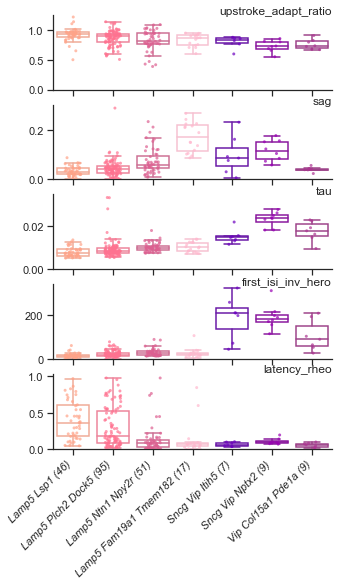

In [105]:
features = ['upstroke_adapt_ratio',
           'sag',
#            'sag_peak_t',
           'tau',
           'first_isi_inv_hero',
           'latency_rheo',
           ]
# labels = [efeat_units[feat] for feat in features]
labels=None
utils.plot_boxplot_multiple(anova_df, features, labels=labels, x='cluster_plot', figsize=(5,8), palette=palette_mouse)

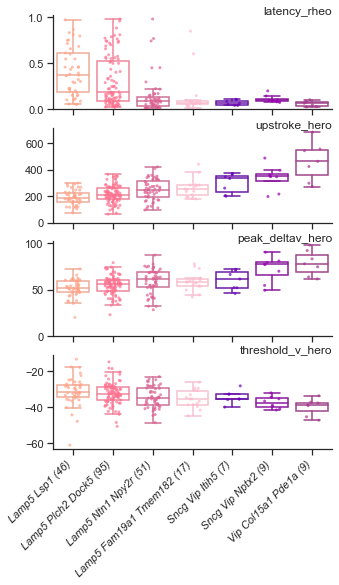

In [108]:
features = [
           'latency_rheo',
    'upstroke_hero',
            'peak_deltav_hero',
            'threshold_v_hero',
           ]
labels=None
utils.plot_boxplot_multiple(anova_df, features, labels=labels, x='cluster_plot', figsize=(5,8), palette=palette_mouse)

## Load lims ephys

In [ ]:
import ipfx.bin.features_from_output_json as feat
from ipfx.lims_queries import get_fx_output_json
import allensdk.core.json_utilities as ju

file_list = [get_fx_output_json(cell) for cell in inh_df.index]

fcn = feat.extract_fx_output
files = file_list
cell_ids = inh_df.index
records = []
index_var = 'specimen_id'
for i, file in enumerate(files):
    if file.startswith('/') and file.endswith('json'):
        fx_dict = ju.read(file)
        cell_features = fx_dict.get('cell_features', {})
        record = fcn(cell_features)
        record[index_var] = cell_ids[i]
        records.append(record)
ephys_df = pd.DataFrame.from_records(records, index=index_var)

In [ ]:
sns.displot(ephys_df.peak_deltav_hero)

# K channel recordings

In [14]:
channels_df = pd.read_csv("/home/tom.chartrand/projects/human_l1/L1_homologous_channel_cells.csv", index_col=1)
channels_df.head()

Unnamed: 0  total_v_half  total_slope  \
cell_name                                                                      
H19.03.305.11.10.01.06                         11     -6.370183    13.678684   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02          52           NaN          NaN   
H19.03.319.11.04.01.01                         54    -10.453496     9.909890   
H19.03.323.11.04.01.05                         77      1.428486    14.016928   
H19.06.351.11.16.02.03                        125     15.516560    10.017801   

                                       slow_v_half  slow_slope  fast_v_half  \
cell_name                                                                     
H19.03.305.11.10.01.06                         NaN         NaN     7.456774   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02          NaN         NaN          NaN   
H19.03.319.11.04.01.01                  -18.446655   11.155533     2.644184   
H19.03.323.11.04.01.05                         NaN         NaN   -40.481452   
H19.06.351.11.16.02.03                    9.238993   11.119369     4.466508   

                                       fast_slope  sus_v_half  sus_slope  \
cell_name                                                                  
H19.03.305.11.10.01.06                  17.809239         NaN        NaN   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02         NaN         NaN        NaN   
H19.03.319.11.04.01.01                  15.032388   33.617053  13.161699   
H19.03.323.11.04.01.05                  44.257497         NaN        NaN   
H19.06.351.11.16.02.03                  59.810200   -3.398264   2.273635   

                                       total_peak_current  \
cell_name                                                   
H19.03.305.11.10.01.06                         864.770813   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                 NaN   
H19.03.319.11.04.01.01                        1041.547607   
H19.03.323.11.04.01.05                         511.423248   
H19.06.351.11.16.02.03                        1598.805298   

                                       total_current_density  \
cell_name                                                      
H19.03.305.11.10.01.06                              6.744556   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                    NaN   
H19.03.319.11.04.01.01                              5.805377   
H19.03.323.11.04.01.05                              2.604785   
H19.06.351.11.16.02.03                              7.144319   

                                       total_conductance  \
cell_name                                                  
H19.03.305.11.10.01.06                          5.086887   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                NaN   
H19.03.319.11.04.01.01                          6.126751   
H19.03.323.11.04.01.05                          3.008372   
H19.06.351.11.16.02.03                          9.404737   

                                       total_conductance_density  \
cell_name                                                          
H19.03.305.11.10.01.06                                  0.039674   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                        NaN   
H19.03.319.11.04.01.01                                  0.034149   
H19.03.323.11.04.01.05                                  0.015322   
H19.06.351.11.16.02.03                                  0.042025   

                                       slow_peak_current  \
cell_name                                                  
H19.03.305.11.10.01.06                               NaN   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                NaN   
H19.03.319.11.04.01.01                        608.312988   
H19.03.323.11.04.01.05                               NaN   
H19.06.351.11.16.02.03                       1400.537842   

                                       slow_current_density  slow_conductance  \
cell_name                                                                       
H19.03.305.11.10.01.06           

In [29]:
channels = combined_all.join(channels_df, on='cell_name', rsuffix='_r', how='inner')
channels = channels.query('homology_type!="VIP"')
channels.homology_type.cat.remove_unused_categories(inplace=True)

In [40]:
channels.groupby(['homology_type','species']).slow_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
PAX6           human      1.0
               mouse      NaN
LAMP5          human      7.0
               mouse      1.0
MC4R           human      2.0
               mouse      1.0
Name: slow_conductance_density, dtype: float64

In [41]:
channels.groupby(['homology_type','species']).fast_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
PAX6           human      2.0
               mouse      NaN
LAMP5          human      9.0
               mouse      2.0
MC4R           human      4.0
               mouse      2.0
Name: fast_conductance_density, dtype: float64

In [42]:
channels.groupby(['homology_type','species']).total_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
PAX6           human       4.0
               mouse       NaN
LAMP5          human      10.0
               mouse       2.0
MC4R           human       5.0
               mouse       3.0
Name: total_conductance_density, dtype: float64

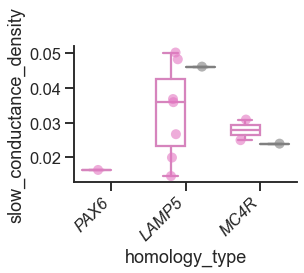

In [32]:
y = "slow_conductance_density"
plot.box_strip(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)

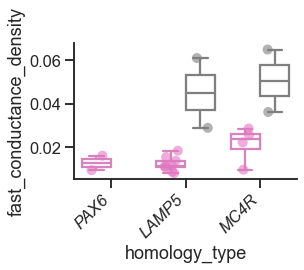

In [33]:
y = "fast_conductance_density"
plot.box_strip(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)

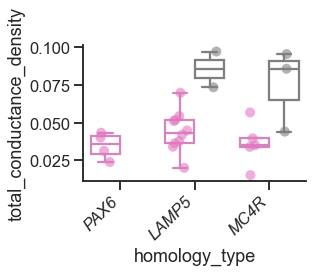

In [35]:
y = "total_conductance_density"
plot.box_strip(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)